## BiTCN 处理粮食期货问题

### 1.导入需要的库

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import BiTCN
from neuralforecast.losses.pytorch import GMM

### 2.导入数据

In [2]:
# 导入数据

file_path = "oil_lagx.csv"
Y_df = pd.read_csv(file_path)


# 显示数据
print(Y_df.head())

# 检查数据基本信息
print(Y_df.info())


        date     value      lag1  lag5  lag22  scci_lag5    bdi_lag1  \
0  2018/4/18  0.997407       NaN   NaN    NaN     6.9784  356.715249   
1  2018/4/19  1.228911  0.997407   NaN    NaN    17.6785 -107.047314   
2  2018/4/20  0.942741  1.228911   NaN    NaN   -21.6329  -53.595469   
3  2018/4/21  1.264519  0.942741   NaN    NaN     7.9088  927.731720   
4  2018/4/22  1.040070  1.264519   NaN    NaN     6.5132   97.251799   

     bdi_lag2    bdi_lag3    bdi_lag4  
0  124.392595  246.029161 -299.833805  
1  356.715249  124.392595  246.029161  
2 -107.047314  356.715249  124.392595  
3 -171.766971 -253.592671  -53.595469  
4  927.731720 -171.766971 -253.592671  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1256 non-null   object 
 1   value      1256 non-null   float64
 2   lag1       1255 non-null   float64
 3   lag5       1251

### 3.数据处理

In [3]:
# 删去最后五列
Y_df1 = Y_df.drop(Y_df.columns[-5:], axis = 1)

# 删去缺失值的行
Y_df2 = Y_df1.dropna()

# 显示数据
print(Y_df2.head())

         date     value      lag1      lag5     lag22
22  2018/5/10  2.006319  1.324862  1.562559  1.371308
23  2018/5/11  1.175668  2.006319  1.669167  1.417167
24  2018/5/12  1.328974  1.175668  1.369693  1.414747
25  2018/5/13  1.631642  1.328974  1.433459  1.432303
26  2018/5/14  1.582122  1.631642  1.493493  1.448991


In [4]:
# 转化为d
Y_df2['date'] = pd.to_datetime(Y_df2['date'], errors='coerce')  # 将 'date' 转换为 datetime 类型
Y_df2.loc[:, 'date'] = Y_df2['date'].dt.date  # 现在可以使用 .dt 访问器
# 对齐时间

# 按日期排序
Y_df2 = Y_df2.sort_values(by='date')

# 获取从数据第一行到最后一行的日期顺序
Y_df2['date'] = pd.date_range(start=Y_df2['date'].min(), periods=len(Y_df2), freq='D')

# 查看结果
print(Y_df2)


           date     value      lag1      lag5     lag22
22   2018-05-10  2.006319  1.324862  1.562559  1.371308
23   2018-05-11  1.175668  2.006319  1.669167  1.417167
24   2018-05-12  1.328974  1.175668  1.369693  1.414747
25   2018-05-13  1.631642  1.328974  1.433459  1.432303
26   2018-05-14  1.582122  1.631642  1.493493  1.448991
...         ...       ...       ...       ...       ...
1251 2021-09-20  1.702458  1.736231  1.606785  1.846500
1252 2021-09-21  1.469298  1.702458  1.632582  1.837880
1253 2021-09-22  1.723840  1.469298  1.655817  1.815043
1254 2021-09-23  1.421625  1.723840  1.678352  1.821289
1255 2021-09-24  1.169950  1.421625  1.610690  1.804882

[1234 rows x 5 columns]


/tmp/ipykernel_3221/826687272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_df2['date'] = pd.to_datetime(Y_df2['date'], errors='coerce')  # 将 'date' 转换为 datetime 类型


In [5]:
# 插入新列unique_id
Y_df2.insert(0, 'unique_id', 1)

# 将date换名ds，value换成y
Y_df2 = Y_df2.rename(columns={'date': 'ds', 'value': 'y'}).reset_index(drop=True)

# 查看结果
print(Y_df2)



      unique_id         ds         y      lag1      lag5     lag22
0             1 2018-05-10  2.006319  1.324862  1.562559  1.371308
1             1 2018-05-11  1.175668  2.006319  1.669167  1.417167
2             1 2018-05-12  1.328974  1.175668  1.369693  1.414747
3             1 2018-05-13  1.631642  1.328974  1.433459  1.432303
4             1 2018-05-14  1.582122  1.631642  1.493493  1.448991
...         ...        ...       ...       ...       ...       ...
1229          1 2021-09-20  1.702458  1.736231  1.606785  1.846500
1230          1 2021-09-21  1.469298  1.702458  1.632582  1.837880
1231          1 2021-09-22  1.723840  1.469298  1.655817  1.815043
1232          1 2021-09-23  1.421625  1.723840  1.678352  1.821289
1233          1 2021-09-24  1.169950  1.421625  1.610690  1.804882

[1234 rows x 6 columns]


In [6]:
Y_df3 = Y_df2# 特征仅lag使用

In [ ]:
# 特征滞后一个时间单位以保证本期特征预测下一期（有其他外生变量用）

# 提取y列
col = Y_df2['y']

# 删除第一个观测值
col_1 = col.drop(col.index[0])

# 将下面的观测值往上递补一位
col_2 = col_1.reset_index(drop=True)

# 将处理后的列重新赋值给DataFrame
Y_df2['y'] = col_2

# 删除最后一行
Y_df3 = Y_df2.drop(Y_df2.index[-1])


In [68]:
# 划分训练测试集，90% 用于训练集，10% 用于测试集
train_size = int(len(Y_df3) * 0.59-6)

# 划分训练集和测试集
train_Y_df3 = Y_df3[:train_size]
test_Y_df3 = Y_df3[train_size:].reset_index(drop=True)

# 打印训练集和测试集的大小
print(f"训练集大小: {len(train_Y_df3)}")
print(f"测试集大小: {len(test_Y_df3)}")

训练集大小: 722
测试集大小: 512


### 4.初始化模型

In [69]:
futr_exog_list = Y_df3.columns[3:].tolist() # 历史外生变量列名列名

In [70]:
models = [BiTCN(h=2,
                input_size = 24,
                hidden_size=32,
                dropout=0.1,
                learning_rate=1e-3,
                futr_exog_list = futr_exog_list,
                loss=GMM(n_components=4, return_params=True, level=[80,90]),
                scaler_type = 'standard',
                max_steps=200,
                batch_size = 32
                )]

Seed set to 1


###  5.滚动预测（拓展非拓展在于train_Y_df3 = Y_df3.iloc[i:train_size + i]）

In [71]:
import time
start_time = time.time()

predictions = []

for i in range(0, len(test_Y_df3),2):
    train_Y_df3 = Y_df3.iloc[i:train_size + i]
    test_Y_df3 = Y_df3.iloc[train_size + i : train_size + i+2]
    nf = NeuralForecast(models=models, freq='D')
    nf.fit(df=train_Y_df3)
    Y_hat_df = nf.predict(futr_df=test_Y_df3)
    print(Y_hat_df.head)
    print(Y_hat_df.shape)
    prediction = Y_hat_df['BiTCN-median'].values.flatten()
    predictions.append(prediction)

end_time = time.time()
print(f" Code running time: {end_time - start_time} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
-------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-05-01  2.433647      2.432082     2.273576     2.310668   
1          1 2020-05-02  1.863098      1.829394     1.247354     1.298350   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.568548     2.604228    2.496837     0.090797    2.429340     0.097648   
1     2.426917     2.517050    2.184366     0.232621    1.317336     0.106824   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.410857     0.086716    2.385329     0.086820  
1    1.664128     0.109160    2.296367     0.205628  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-05-03  1.094457      1.091727     0.951488     0.979121   
1          1 2020-05-04  1.591054      1.579195     1.069928     1.113257   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.214921     1.251779    1.119536     0.090505    1.060850     0.090094   
1     2.064354     2.150278    1.666029     0.128549    1.129389     0.090762   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.116430     0.089962    1.074501     0.090121  
1    1.522048     0.091618    2.024678     0.144647  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-05-05  1.456463      1.452676     1.311912     1.344106   
1          1 2020-05-06  1.639161      1.514968     1.122184     1.184195   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.571923     1.608861    1.453644     0.092684    1.451985     0.091710   
1     2.352290     2.582345    1.775068     0.444791    1.244434     0.106149   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.466593     0.091333    1.449132     0.091497  
1    1.494488     0.105000    2.091578     0.508789  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-05-07  3.134910      3.123999     2.919511     2.966088   
1          1 2020-05-08  1.836379      1.809407     1.307075     1.354549   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.312577     3.398654    3.139542     0.094726    3.257177     0.156253   
1     2.375169     2.484404    2.066097     0.128330    1.401208     0.127751   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    3.114641     0.096212    3.018691     0.093803  
1    1.550634     0.119634    2.320347     0.188936  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-05-09  1.555586      1.553216     1.386446     1.417905   
1          1 2020-05-10  1.792136      1.723710     1.347246     1.406517   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.692882     1.734743    1.587055     0.106384    1.511699     0.104743   
1     2.299437     2.495044    1.991263     0.225477    1.457189     0.121592   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.522624     0.104359    1.590920     0.104606  
1    1.666056     0.117552    2.086039     0.450230  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-05-11  1.910826      1.906304     1.747162     1.782974   
1          1 2020-05-12  1.822421      1.721291     1.428806     1.471770   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.045541     2.080733    1.898894     0.103194    1.888051     0.103688   
1     2.335066     2.501364    1.913847     0.275276    1.531059     0.108726   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.931804     0.102913    1.920636     0.103237  
1    1.670213     0.104885    2.200496     0.331193  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-05-13  1.245548      1.241644     1.067120     1.107598   
1          1 2020-05-14  1.654824      1.621427     1.402458     1.443917   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.381605     1.428812    1.216519     0.098106    1.314139     0.097969   
1     1.921022     2.013378    1.878180     0.168899    1.513742     0.098443   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.260850     0.097695    1.188757     0.098064  
1    1.595675     0.097912    1.678003     0.184678  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-05-15  2.293772      2.290439     2.128124     2.164376   
1          1 2020-05-16  1.860588      1.869445     1.488446     1.538193   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.421340     2.463116    2.300709     0.102100    2.287935     0.108193   
1     2.183473     2.254791    2.026653     0.108241    1.560822     0.108441   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.275609     0.102321    2.303656     0.103208  
1    1.752344     0.101738    2.109102     0.160374  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-05-17  1.466910      1.467622     1.281518     1.317760   
1          1 2020-05-18  1.557841      1.576339     1.248852     1.297226   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.611752     1.652755    1.508853     0.101678    1.368587     0.100706   
1     1.787284     1.847578    1.659831     0.142283    1.320097     0.102054   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.507670     0.100383    1.474326     0.101338  
1    1.617053     0.100083    1.655145     0.162498  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-05-19  2.037183      2.037277     1.859066     1.907628   
1          1 2020-05-20  1.929377      1.847205     1.228125     1.544092   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.176070     2.210998    1.974649     0.103102    2.054488     0.103053   
1     2.574935     2.857091    2.036933     0.866944    1.826596     0.134455   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.075922     0.101866    2.045012     0.102047  
1    1.773113     0.103594    2.225030     0.391745  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-05-21  1.579198      1.576701     1.407426     1.445470   
1          1 2020-05-22  1.754654      1.424923     0.812449     1.166573   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.719687     1.755833    1.545427     0.102524    1.610509     0.102143   
1     2.904088     3.466489    2.357325     1.655919    1.319249     0.106283   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.608843     0.101562    1.550602     0.101911  
1    1.357158     0.101412    2.257652     0.535013  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-05-23  1.272221      1.269114     1.110427     1.151044   
1          1 2020-05-24  1.701673      1.748641     1.034628     1.081515   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.400747     1.431100    1.244181     0.096623    1.284614     0.096452   
1     2.192447     2.271885    2.188599     0.133424    1.098972     0.098217   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.302543     0.096080    1.255911     0.096279  
1    1.598510     0.096118    1.930909     0.127405  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-05-25  1.877192      1.875733     1.726685     1.757300   
1          1 2020-05-26  1.581384      1.499301     1.061736     1.220631   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.999349     2.039804    1.879281     0.094700    1.900144     0.094925   
1     2.097179     2.540431    2.031553     0.815218    1.507452     0.170894   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.881357     0.091051    1.842522     0.090749  
1    1.462432     0.102743    1.507835     0.307054  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-05-27  1.297713      1.296511     1.156879     1.185502   
1          1 2020-05-28  1.596545      1.510896     0.921672     0.975191   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.411773     1.446202    1.305954     0.092377    1.283240     0.089748   
1     2.227749     2.435013    2.189536     0.393252    0.995117     0.112109   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.292069     0.089331    1.303472     0.090122  
1    1.360719     0.090130    1.897989     0.178065  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-05-29  2.730476      2.727962     2.519761     2.564765   
1          1 2020-05-30  1.569413      1.491006    -0.388354     0.986109   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.899123     2.969442    2.646138     0.100462    2.841742     0.130760   
1     2.368759     3.604534    1.990659     2.585416    1.443056     0.195752   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.652028     0.094073    2.779173     0.094810  
1    1.409957     0.100655    1.873812     0.275797  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-05-31  1.297298      1.294849     1.137885     1.174037   
1          1 2020-06-01  1.610727      1.611405     1.070506     1.145498   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.418840     1.455794    1.287425     0.099328    1.303978     0.098031   
1     2.051039     2.523984    1.990619     0.854447    1.210370     0.108656   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.290741     0.097676    1.302245     0.097831  
1    1.600589     0.099136    1.779829     0.138071  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-06-02  2.095528      2.091654     1.952186     1.984077   
1          1 2020-06-03  1.662893      1.611889     0.827614     1.356732   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.204238     2.252025    2.077572     0.091183    2.133213     0.091579   
1     2.023615     2.899526    2.062085     1.341574    1.542933     0.126185   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.070468     0.081703    2.095751     0.080035  
1    1.611079     0.086942    1.684205     0.147861  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-06-04  1.350176      1.347832     1.222732     1.250208   
1          1 2020-06-05  1.665382      1.601941     1.166351     1.211231   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.448108     1.482733    1.362120     0.080762    1.348765     0.079576   
1     2.210306     2.615045    2.234161     0.610174    1.243629     0.094987   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.336534     0.078948    1.347235     0.079099  
1    1.553457     0.079937    1.744938     0.125164  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-06-06  1.134962      1.131479     1.004143     1.033587   
1          1 2020-06-07  1.443686      1.449350     0.718919     0.772958   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.239218     1.268754    1.124237     0.083962    1.136503     0.082984   
1     2.126535     2.533617    1.912610     0.994849    0.821061     0.094725   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.142582     0.082608    1.133154     0.083206  
1    1.449475     0.083069    1.736865     0.273874  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-06-08  1.758372      1.755538     1.613790     1.647168   
1          1 2020-06-09  1.527046      1.377535     0.345885     1.068448   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.880246     1.903334    1.734014     0.088324    1.766665     0.087318   
1     2.268103     3.474047    2.209684     2.025501    1.211021     0.092386   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.799039      0.08491    1.732354     0.083977  
1    1.380498      0.08549    1.667657     0.299491  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-06-10  2.813550      2.791264     2.587370     2.632745   
1          1 2020-06-11  1.805346      1.705655     1.123998     1.228874   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.025492     3.100263     2.90623     0.125160    2.875792     0.189420   
1     2.346502     2.945802     2.25247     1.110712    1.310822     0.124971   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.703273     0.092074    2.742700     0.086049  
1    1.663308     0.086493    2.159722     0.098749  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-06-12  2.088975      2.087506     1.931831     1.964274   
1          1 2020-06-13  1.792157      1.680782     1.182042     1.255774   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.213541     2.251311    2.100030     0.099139    2.095715     0.101003   
1     2.393243     2.937897    2.316149     0.996035    1.323940     0.124512   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.078038     0.097477    2.075071     0.096801  
1    1.625683     0.106756    2.065312     0.170375  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-06-14  1.459951      1.455747     1.306653     1.335351   
1          1 2020-06-15  1.694049      1.788821     0.907795     0.972744   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.586160     1.624169    1.472245     0.098335    1.412324     0.099227   
1     2.270687     2.401569    1.920310     0.382559    0.997303     0.131501   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.474427     0.097957    1.474614     0.098069  
1    1.807603     0.108959    2.072048     0.281352  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-06-16  1.273047      1.270814     1.110600     1.148932   
1          1 2020-06-17  1.637501      1.622733     1.073176     1.127208   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.398494     1.438974    1.256506     0.098334    1.292585     0.098551   
1     2.155895     2.301889    1.767061     0.174701    1.147325     0.113183   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.260048     0.098049    1.278749     0.098181  
1    1.544369     0.109138    2.082623     0.252516  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-06-18  1.489577      1.485968     1.328196     1.359614   
1          1 2020-06-19  1.630485      1.672151     0.973253     1.066538   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.618612     1.659692    1.484218     0.101957    1.452687     0.104320   
1     2.079911     2.245547    1.841338     0.113756    1.101875     0.196333   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.492449     0.101841    1.523730     0.102908  
1    1.574940     0.117324    1.996783     0.286487  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-06-20  1.619931      1.618109     1.454005     1.482791   
1          1 2020-06-21  1.525740      1.511510     1.115669     1.173340   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.749022     1.790119    1.628173     0.099406    1.548601      0.09875   
1     1.914918     2.067005    1.360344     0.188198    1.255610      0.13517   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.624331     0.098155    1.672311     0.099043  
1    1.644270     0.113204    1.840354     0.261022  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-06-22  1.989532      1.988185     1.822519     1.857684   
1          1 2020-06-23  1.949350      1.753784     0.713564     1.205070   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.120820     2.157453    1.986076     0.105422    1.984928     0.104092   
1     3.211126     3.688928    2.062479     1.033183    1.654211     0.116622   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.969415     0.104067    2.011504     0.104437  
1    1.773986     0.108960    2.473217     1.247436  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-06-24  2.532112      2.528736     2.368760     2.404816   
1          1 2020-06-25  1.892330      1.862251     1.575227     1.620367   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.660307     2.706280    2.536055     0.097193    2.547665     0.106652   
1     2.214794     2.285194    2.044588     0.140904    1.738096     0.115969   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0     2.49244     0.097058    2.544719     0.098330  
1     1.69277     0.100062    2.117828     0.173512  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-06-26  1.454181      1.452620     1.294428     1.329345   
1          1 2020-06-27  1.638418      1.672086     1.190745     1.240224   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.582163     1.625841    1.487403     0.099392    1.414413     0.099605   
1     1.973268     2.091455    1.805554     0.111398    1.261355     0.102525   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.440376     0.099049    1.465492     0.099919  
1    1.642150     0.099381    1.850552     0.269718  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-06-28  1.433076      1.430331     1.270533     1.299075   
1          1 2020-06-29  1.568644      1.499732     1.156063     1.204477   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.563083     1.605013    1.436743     0.103040    1.382386     0.102857   
1     2.051251     2.140285    1.469473     0.107115    1.223783     0.103369   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.432086     0.102812    1.474942     0.103644  
1    1.542642     0.101973    2.010140     0.149881  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-06-30  1.585454      1.582024     1.431679     1.461783   
1          1 2020-07-01  1.751707      1.630411     1.296786     1.358526   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.707099     1.749513    1.585878     0.099126    1.586007     0.098892   
1     2.341744     2.552365    1.857989     0.316265    1.600503     0.123470   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.592840     0.098334    1.571925     0.099667  
1    1.436741     0.101695    2.157566     0.434592  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-07-02  2.071404      2.068936     1.921114     1.951204   
1          1 2020-07-03  1.835322      1.625454     1.304492     1.388427   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.194368     2.229748    2.074666     0.095691    2.051823     0.096606   
1     2.621680     2.803833    1.969607     0.625848    1.552816     0.124497   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.051519     0.094975    2.101241     0.096418  
1    1.506793     0.099839    2.389022     0.366458  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-07-04  2.536788      2.534103     2.380474     2.413098   
1          1 2020-07-05  1.952839      1.853116     1.599058     1.660057   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.659707     2.701614    2.510960     0.094851    2.577247     0.099262   
1     2.408244     2.561563    2.123432     0.446078    1.746737     0.096172   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.539674     0.094800    2.516428     0.095489  
1    1.786988     0.093764    2.222316     0.221079  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-07-06  1.294630      1.290952     1.148354     1.183557   
1          1 2020-07-07  1.846598      1.815262     1.234406     1.277096   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.413440     1.438636    1.268056     0.089085    1.289803     0.088688   
1     2.461668     2.650959    1.926484     0.149329    1.292989     0.089423   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.324655     0.088337    1.294570     0.088701  
1    1.766152     0.088592    2.374262     0.318656  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-07-08  1.481667      1.480107     1.337305     1.366819   
1          1 2020-07-09  1.819448      1.754309     1.235945     1.295955   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.594658     1.628629    1.478436     0.090740    1.488740     0.090439   
1     2.356657     2.619466    2.061713     0.129293    1.323086     0.118391   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.466309     0.090096    1.488002     0.091088  
1    1.667121     0.093829    2.224758     0.454563  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-07-10  0.974979      0.975183     0.824604      0.85592   
1          1 2020-07-11  1.475950      1.361389     0.850269      0.89881   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.092095     1.132738    0.991536     0.095207    0.965131     0.094533   
1     2.269455     2.532484    1.615060     0.106713    0.917165     0.098280   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    0.974858     0.094456    0.961695     0.095138  
1    1.189867     0.094794    2.148000     0.442787  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-07-12  1.692935      1.692366     1.539370     1.574337   
1          1 2020-07-13  1.530411      1.471958     1.164558     1.238261   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.815131     1.847444    1.685022     0.096778    1.676480     0.097282   
1     1.941927     2.060880    1.467855     0.304906    1.477662     0.109874   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.693892     0.095849    1.711671     0.096788  
1    1.362562     0.099447    1.851502     0.224688  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-07-14  1.793795      1.791131     1.639583     1.675040   
1          1 2020-07-15  1.683972      1.586701     1.200963     1.359503   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.920346     1.955330    1.789204     0.099074    1.779534     0.097093   
1     2.206187     2.415642    1.899228     0.748506    1.498986     0.106407   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.814139     0.096087    1.787853     0.096158  
1    1.531678     0.099962    1.930277     0.237451  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-07-16  1.857266      1.856399     1.714797     1.746365   
1          1 2020-07-17  1.656009      1.559964     0.949262     1.305385   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.970178     2.006968    1.874135     0.090573    1.841551     0.089449   
1     2.179244     2.624591    1.947444     1.084784    1.485422     0.129954   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.832348     0.088270    1.873474     0.088038  
1    1.482924     0.093465    1.892676     0.184537  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-07-18  2.874776      2.858681     2.673939     2.712103   
1          1 2020-07-19  1.702552      1.622434     0.995282     1.359510   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.047005     3.130947    2.795839     0.095062    2.991765     0.154995   
1     2.128868     2.790869    2.065115     1.162652    1.577587     0.120741   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.915152     0.094557    2.796095     0.087351  
1    1.512694     0.093807    1.863464     0.135115  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-07-20  1.392563      1.392732     1.228304     1.259657   
1          1 2020-07-21  1.609193      1.633381     0.967475     1.050111   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.524086     1.556978    1.411343     0.098234    1.310293     0.093466   
1     2.210271     2.408159    1.781030     0.771292    1.114102     0.104366   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.422837      0.09281    1.419313     0.092662  
1    1.635845      0.09853    1.997547     0.227874  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-07-22  2.260217      2.258804     2.088310     2.125228   
1          1 2020-07-23  1.715782      1.644359     0.658926     1.059037   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.395824     2.433876    2.267076     0.097676    2.250583     0.118415   
1     2.584911     3.276331    2.221565     1.689728    1.280723     0.212492   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.203826     0.094680    2.309843     0.096021  
1    1.678472     0.144955    1.970837     0.420886  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-07-24  1.475226      1.472031     1.317845     1.356919   
1          1 2020-07-25  1.574165      1.530478     0.579337     0.920425   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.605211     1.631516    1.466977     0.095122    1.486181     0.093902   
1     2.427469     2.886285    1.944579     1.483691    1.080153     0.160617   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.507973     0.093165    1.436465     0.093179  
1    1.567956     0.139486    1.936055     0.402062  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-07-26  1.397318      1.391174     1.224683     1.253335   
1          1 2020-07-27  1.487915      1.336976     0.817773     0.920599   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.543816     1.585808    1.388331     0.097437    1.321113     0.096369   
1     2.286551     2.516007    1.732428     0.938760    0.993071     0.105152   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.375398     0.094779    1.498664     0.095379  
1    1.301760     0.097707    2.039892     0.264225  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-07-28  1.366219      1.359329     1.205740     1.234788   
1          1 2020-07-29  1.585999      1.547199     0.647357     1.083551   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.500272     1.529660    1.349489     0.100919    1.304224     0.093995   
1     2.336363     2.678615    1.793112     1.240423    1.242088     0.107530   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.416178     0.093643    1.392291     0.093520  
1    1.596016     0.108258    1.903974     0.394556  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-07-30  1.902944      1.901515     1.751869     1.783099   
1          1 2020-07-31  1.776064      1.700083     1.078864     1.215478   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.023897     2.065809    1.918847     0.101446    1.878553     0.097795   
1     2.592634     2.873664    2.032135     0.766865    1.315352     0.143061   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.898062     0.094374    1.908565     0.091904  
1    1.748057     0.159345    2.126400     0.589094  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-08-01  1.446998      1.399475     0.923664     1.067411   
1          1 2020-08-02  2.079040      2.012587    -1.059633     0.136240   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.880551     2.236405    1.595399     0.666129    1.305659     0.206498   
1     4.223439     5.361429    2.007873     1.982566    1.804743     0.206239   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.381497     0.240723    1.439858     0.205241  
1    2.293235     0.229614    2.575706     2.888015  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-08-03  1.918611      1.911327     1.580611     1.662005   
1          1 2020-08-04  1.904339      1.776589     1.339706     1.407414   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.187245     2.262051    1.863370     0.204073    1.947288     0.210139   
1     2.640957     2.840338    1.795291     0.212466    1.524825     0.214466   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.954594     0.205251    1.904316     0.208810  
1    1.737436     0.209623    2.548892     0.335642  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-08-05  1.369167      1.361534     1.047308     1.121405   
1          1 2020-08-06  1.456577      1.251817     0.598028     0.692820   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.623461     1.702096     1.34239     0.199361    1.395268     0.201598   
1     2.694525     3.182820     1.31839     0.291735    0.752936     0.209760   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.377164     0.199074    1.353711     0.201357  
1    1.251516     0.202373    2.469053     0.822005  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-08-07  1.652942      1.644046     1.325713     1.402855   
1          1 2020-08-08  1.753950      1.567389     1.012870     1.107306   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.914302     1.984562    1.617524     0.200785    1.633286     0.203133   
1     2.764439     2.990294    1.642636     0.221963    1.157362     0.209799   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.685762     0.201219     1.66855     0.203925  
1    1.514345     0.201799     2.66015     0.380208  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-08-09  1.557104      1.554874     1.216041     1.285936   
1          1 2020-08-10  1.718018      1.618879     1.096253     1.229024   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.830228     1.929093    1.598004     0.202725    1.626576     0.204956   
1     2.319282     3.033041    2.361350     1.076044    1.673813     0.261067   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.502583     0.201786    1.484636     0.201345  
1    1.561487     0.203595    1.532815     0.258983  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-08-11  2.226148      2.215052     1.898635     1.973162   
1          1 2020-08-12  1.952513      1.835725     1.056268     1.223193   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.494066     2.558300    2.189826     0.205556    2.204726     0.205250   
1     2.838159     4.043345    2.909191     1.816905    1.363234     0.213565   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.275769     0.202522    2.227736     0.201311  
1    1.852834     0.208280    2.026111     0.264339  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-08-13  1.184585      1.181176     0.848560     0.925544   
1          1 2020-08-14  1.641151      1.455468     0.923978     1.017133   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.456740     1.524845    1.112738     0.198672    1.229836     0.198363   
1     2.506819     2.935683    2.528913     0.651641    1.145008     0.205203   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.245309     0.197250    1.148341     0.197368  
1    1.250396     0.204939    1.792053     0.292561  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-08-15  1.568803      1.561994     1.260946     1.320846   
1          1 2020-08-16  1.650936      1.421684     0.951240     1.052883   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.827084     1.896835    1.570434     0.200205    1.538572     0.198845   
1     2.772450     3.253309    2.800792     0.724929    1.251160     0.202093   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.609617     0.197773    1.546760     0.197375  
1    1.542672     0.200454    1.231603     0.254450  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-08-17  2.406740      2.402644     2.063529     2.138313   
1          1 2020-08-18  2.235502      2.246719     1.471136     1.663355   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.692163     2.757197    2.331669     0.202619    2.451800     0.205348   
1     2.810201     2.915181    2.361511     0.381163    1.804954     0.480237   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.497647      0.19858    2.344431     0.197941  
1    2.141778      0.20997    2.679557     0.232966  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-08-19  2.580180      2.575933     2.259623     2.315758   
1          1 2020-08-20  1.938667      1.759276     1.346483     1.439317   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.837057     2.928138    2.566233     0.198095    2.652483     0.200220   
1     2.831910     3.091024    2.847182     0.390633    1.628860     0.245886   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.553260     0.196219    2.538195     0.195676  
1    1.652479     0.196729    1.768926     0.206787  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-08-21  2.078078      2.069246     1.704738     1.787561   
1          1 2020-08-22  2.237662      1.975147     1.228442     1.396418   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.366898     2.457289    2.033136     0.218920    2.177840     0.216107   
1     3.438390     4.750027    3.515697     1.977388    1.544801     0.245907   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.102398     0.214591    1.992027     0.212864  
1    1.878470     0.227467    2.394854     0.369059  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-08-23  1.739753      1.733584     1.386409     1.469332   
1          1 2020-08-24  2.232747      2.076045     1.570744     1.661443   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.012552      2.10211    1.673381     0.213309    1.795574     0.213626   
1     3.093924      3.41858    3.113059     0.489442    1.881510     0.225529   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.762703     0.212677    1.722662     0.212998  
1    1.827826     0.214075    2.252738     0.249888  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-08-25  1.697518      1.692738     1.497424     1.543995   
1          1 2020-08-26  1.863420      1.794670     1.130720     1.250607   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.866683     1.899373    1.672239     0.122296    1.708265     0.121570   
1     2.650061     3.361143    2.557281     1.287780    1.342460     0.137522   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.747261     0.119817    1.659587     0.120123  
1    1.849997     0.129934    1.940634     0.361294  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-08-27  1.714002      1.711095     1.518554     1.560655   
1          1 2020-08-28  1.912647      1.853365     1.263802     1.325845   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.864868     1.917017    1.738607     0.120325    1.716435     0.119468   
1     2.603486     2.834074    2.617077     0.347628    1.348944     0.129963   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.670295     0.118378    1.720231     0.118568  
1    1.721498     0.121558    2.036795     0.159786  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-08-29  1.857488      1.854103     1.663090     1.699914   
1          1 2020-08-30  1.719846      1.655426     1.107525     1.230094   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.013203     2.064047     1.86313     0.122497    1.826982     0.123604   
1     2.312523     2.789556     2.17823     0.979340    1.343589     0.183391   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.823487     0.121594    1.907684     0.121836  
1    1.628966     0.143570    1.901918     0.228799  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-08-31  4.161660      4.124003     3.816883     3.873642   
1          1 2020-09-01  2.162625      2.065887     0.207213     1.282018   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     4.478888     4.628759    4.305189     0.139428    4.299599     0.347775   
1     3.088455     4.899132    3.002717     3.038042    1.913664     0.555020   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    4.028297     0.126307    3.974737     0.128155  
1    1.944357     0.215770    2.351099     0.357469  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-09-02  1.836600      1.834433     1.580354     1.640735   
1          1 2020-09-03  1.945691      1.971474     1.398360     1.472374   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.026629     2.093813    1.763434     0.146795    1.899569     0.147302   
1     2.381222     2.506094    2.260017     0.270878    1.500967     0.156623   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.812624     0.145988    1.868581     0.145974  
1    1.847959     0.149930    2.210276     0.165902  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-09-04  1.366122      1.362608     1.130868     1.176452   
1          1 2020-09-05  1.591704      1.516215     1.147063     1.242708   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.554574     1.614341    1.371966     0.148696    1.374288     0.148913   
1     2.098061     2.262545    2.107755     0.247973    1.422506     0.153912   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.385254     0.148445    1.325080     0.148757  
1    1.583796     0.150756    1.352391     0.196741  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-09-06  2.611179      2.604482     2.317563     2.391478   
1          1 2020-09-07  2.069053      1.937652     1.389271     1.491044   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.834994     2.898980    2.556714     0.177703    2.610726     0.189383   
1     2.790405     3.103522    2.635704     0.749441    1.638453     0.241858   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.637284     0.173550    2.634814     0.168505  
1    1.734674     0.175522    2.403033     0.247479  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-09-08  2.589235       2.58778     2.282478     2.356059   
1          1 2020-09-09  2.394675       2.26746     1.587654     1.688566   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.821393     2.896882    2.608582     0.181414    2.608184     0.182436   
1     3.318670     3.846174    3.349761     0.795250    1.737791     0.214800   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.495324     0.179208    2.629575     0.177410  
1    2.171732     0.180875    2.487620     0.256389  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-09-10  2.888177      2.883072     2.545955     2.617455   
1          1 2020-09-11  2.417413      2.199766     1.672485     1.809661   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.160078     3.279713    2.818666     0.184976    3.071203     0.190419   
1     3.368075     4.357315    3.426380     1.491350    2.025588     0.229549   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.830078     0.185763    2.827173     0.183615  
1    2.042217     0.191823    2.483709     0.276822  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-09-12  2.057133      2.052576     1.754837     1.813949   
1          1 2020-09-13  2.241104      2.109842     1.562360     1.649554   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.301814     2.379352    2.024600     0.185420    2.110829     0.186953   
1     3.122082     3.357325    3.135947     0.354645    1.693319     0.187592   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.079109     0.185430    2.007725     0.185178  
1    2.192932     0.185517    2.058131     0.212180  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-09-14  1.870286      1.867101     1.605056     1.658985   
1          1 2020-09-15  2.064346      2.016270     1.202444     1.288772   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.080233     2.155543    1.891132     0.169668    1.817603     0.171036   
1     2.996576     3.257558    3.011958     0.393449    1.323133     0.180828   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.870625     0.169571    1.890403     0.169476  
1    2.153570     0.171546    1.878644     0.212436  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-09-16  2.496968      2.491387     2.224852     2.280260   
1          1 2020-09-17  2.156330      2.108392     1.271046     1.356634   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.722085     2.789752    2.544436     0.168655    2.425026     0.172176   
1     3.049395     3.360448    3.067728     0.468936    1.388500     0.179286   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.534374     0.167946    2.471388     0.166997  
1    2.010756     0.170790    2.258701     0.213923  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-09-18  1.987129      1.984363     1.716699     1.770846   
1          1 2020-09-19  2.215111      2.182076     1.454124     1.552869   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.201641     2.267719    1.986123     0.167907    2.013224     0.168650   
1     2.941668     3.144448    2.953620     0.305705    1.590275     0.207826   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.949301     0.167411    1.989460     0.167337  
1    1.994028     0.172225    2.390956     0.193092  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-09-20  2.279459      2.276800     2.014332     2.072062   
1          1 2020-09-21  2.147665      1.925436     1.185698     1.312361   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.490811     2.551062    2.271564     0.166636    2.241104     0.167901   
1     3.368834     4.650665    3.444384     1.932455    1.419306     0.175468   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.262529     0.166228    2.333396     0.166270  
1    1.934083     0.187889    2.172039     0.427235  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-09-22  1.465103      1.463997     1.204512     1.253985   
1          1 2020-09-23  1.930915      1.751364     1.422022     1.496369   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.672713     1.744038    1.458715     0.162454    1.503776     0.162778   
1     2.701652     2.867374    1.758588     0.192966    1.688480     0.163902   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.462169     0.162276    1.427544     0.163382  
1    1.634146     0.162662    2.625129     0.278980  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-09-24  1.188142      1.183629     0.909190     0.975412   
1          1 2020-09-25  1.721864      1.584798     1.217903     1.297564   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.407634     1.473428    1.207741     0.169230    1.194757     0.169228   
1     2.450061     2.642031    2.461376     0.289409    1.474625     0.184998   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.215313     0.168897    1.124798     0.169012  
1    1.619659     0.171235    1.452836     0.202994  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-09-26  1.479823      1.476447     1.236970     1.288526   
1          1 2020-09-27  1.907933      1.849528     1.451739     1.509611   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.676343     1.731333    1.496923     0.156629    1.447658     0.155962   
1     2.394954     2.614996    2.381690     0.373755    1.596299     0.183690   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.462548     0.155675    1.501319     0.155765  
1    1.789720     0.162561    1.955152     0.220135  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-09-28  1.824859      1.820714     1.572318     1.626207   
1          1 2020-09-29  1.917440      1.765881     1.216511     1.319073   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.027811     2.090010    1.885474     0.156272    1.751135     0.155665   
1     2.667718     3.288353    2.646360     1.028469    1.404268     0.184996   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.809453     0.155290    1.838575     0.155502  
1    1.681315     0.159699    2.128736     0.257741  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-09-30  1.145875      1.142538     0.914526     0.972019   
1          1 2020-10-01  1.627647      1.366728     0.072611     0.840236   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.329325     1.382420    1.182641     0.138151    1.144830     0.135126   
1     3.054401     4.115686    2.502010     2.585096    1.341228     0.166243   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.174696     0.135070    1.071484     0.134940  
1    1.246963     0.148521    1.899130     0.753261  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-10-02  1.611514      1.610662     1.412768     1.456173   
1          1 2020-10-03  1.786678      1.664359     1.007504     1.312318   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.771536     1.821396    1.647412     0.125421    1.611324     0.121238   
1     2.376167     3.321703    2.386333     1.498456    1.437700     0.135694   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.606290     0.121173    1.570670     0.120946  
1    1.617058     0.126897    1.971357     0.190160  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-10-04  1.370728      1.367794     1.203151     1.238902   
1          1 2020-10-05  1.705882      1.569623     0.862025     1.223697   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.508096     1.562227    1.412415     0.123371    1.353199     0.098212   
1     2.533562     3.199286    2.257951     1.508012    1.372503     0.115492   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.334316     0.097739    1.370287     0.097578  
1    1.574752     0.101561    1.886080     0.368660  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-10-06  1.752068      1.750053     1.607656     1.642945   
1          1 2020-10-07  1.655642      1.558648     1.027900     1.080526   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.864953     1.906363    1.791173     0.088517    1.733851     0.085687   
1     2.258889     2.711194    2.126434     0.936781    1.126503     0.087003   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.716448     0.084873    1.756961     0.084815  
1    1.510332     0.085783    1.996343     0.146297  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-10-08  1.081084      1.080556     0.939119     0.969540   
1          1 2020-10-09  1.454897      1.314131     0.736750     0.952079   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.193564     1.228009    1.091428     0.089231    1.092607     0.087995   
1     2.292574     2.776585    1.976353     1.201393    1.072985     0.106663   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.068807     0.087916    1.065297     0.088530  
1    1.338998     0.099618    1.646214     0.500202  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-10-10  1.063334      1.061893     0.915117     0.951872   
1          1 2020-10-11  1.521953      1.439297     1.124077     1.164482   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.180915     1.219857    1.098627     0.088131    1.068691     0.086494   
1     1.952772     2.282406    1.972200     0.496947    1.202091     0.087885   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.049335     0.086506    1.028207     0.086518  
1    1.351668     0.088337    1.654258     0.106038  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-10-12  1.482056      1.478295     1.334450     1.364575   
1          1 2020-10-13  1.558617      1.505524     0.705858     1.052589   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.601158     1.644812    1.504201     0.110075    1.456807     0.088262   
1     2.202883     2.866971    1.993476     1.399332    1.142064     0.094865   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.465480     0.088159    1.492315     0.087238  
1    1.492005     0.091205    1.830829     0.207318  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-10-14  1.948478      1.945883     1.762134     1.810660   
1          1 2020-10-15  1.760022      1.724765     0.548790     1.234921   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.086653     2.135941    1.941373     0.134018    1.955833     0.103369   
1     2.311224     3.620359    2.378870     1.988857    1.349323     0.102926   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.954648     0.106696    1.934806     0.102376  
1    1.717653     0.115727    1.933291     0.148062  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-10-16  1.507096      1.501759     1.320726     1.371867   
1          1 2020-10-17  1.499014      1.428793     0.258309     0.803912   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.655844     1.697158    1.464435     0.116629    1.471160     0.101727   
1     2.490447     3.209976    2.020508     1.905519    1.001554     0.144578   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.581770     0.101904    1.510537     0.100715  
1    1.518091     0.185542    1.778160     0.531199  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-10-18  2.334228      2.331480     2.172310     2.203443   
1          1 2020-10-19  1.665273      1.681415     1.016155     1.077796   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.466849     2.508562    2.349523     0.102423    2.305971     0.113305   
1     2.150997     2.808550    2.184874     0.999125    1.131649     0.101906   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.350222     0.101830    2.323887     0.098969  
1    1.657449     0.112894    1.848430     0.122577  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-10-20  1.577213      1.517482     0.891396     1.180954   
1          1 2020-10-21  1.816173      1.785570     0.806610     1.176865   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.051646     2.604716    1.648215     0.993989    1.456697     0.173131   
1     2.638682     3.065973    1.993020     1.271687    1.412229     0.180344   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.635874     0.196805    1.483667     0.170434  
1    1.923431     0.186765    2.136281     0.517238  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-10-22  1.333251      1.330032     1.050134     1.121614   
1          1 2020-10-23  1.821939      1.818141     1.295558     1.379510   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.550062     1.615312    1.286994     0.171191    1.367799     0.170659   
1     2.274678     2.409398    2.254434     0.248251    1.420186     0.186731   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.316607     0.170258    1.355873     0.169651  
1    1.745931     0.173468    1.924699     0.185261  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-10-24  3.403226      3.394840     3.093166     3.155663   
1          1 2020-10-25  2.067401      1.909227     0.771809     1.386467   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.639695     3.752284    3.321267     0.176522    3.526966     0.198201   
1     2.952912     4.449040    2.962750     2.381026    1.578536     0.186416   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    3.376336     0.174569    3.383957     0.172902  
1    1.885644     0.191545    2.270138     0.322415  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-10-26  2.852042      2.844491     2.557178     2.622310   
1          1 2020-10-27  2.288907      2.079498     1.597436     1.677906   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.093358     3.158512    2.829641     0.180929    2.866741     0.191714   
1     3.375671     3.802475    3.400826     0.643438    1.730420     0.183237   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.891105     0.181527    2.813621     0.179347  
1    2.141082     0.182298    2.062909     0.204412  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-10-28  1.718715      1.717349     1.433797     1.492730   
1          1 2020-10-29  2.088026      2.037204     1.586575     1.663465   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.946104      2.01563    1.714806     0.181222    1.673221     0.182347   
1     2.574170      2.80356    2.577004     0.362940    1.732047     0.189313   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.722065     0.181257    1.755109     0.180644  
1    2.151304     0.185174    1.988597     0.198135  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-10-30  1.758508      1.755067     1.483427     1.539359   
1          1 2020-10-31  1.976026      1.853112     1.183102     1.345595   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.983106     2.055884    1.783716     0.178866    1.735035     0.179183   
1     2.863462     3.381839    2.894015     0.781490    1.587374     0.212720   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.771395     0.178549    1.732225     0.178184  
1    2.019724     0.217458    1.620314     0.409032  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-11-01  3.150962      3.150582     2.869138     2.924362   
1          1 2020-11-02  2.339801      2.220634     1.348912     1.456827   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.383054     3.457537    3.186073     0.177224    3.126057     0.193799   
1     3.464169     3.876967    3.488499     0.622323    1.497005     0.226055   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    3.162889     0.180537    3.115578     0.177825  
1    1.991809     0.179704    2.516069     0.206510  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-11-03  4.953603      4.931797     4.540646     4.633254   
1          1 2020-11-04  2.566667      2.268713     1.412692     1.686974   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     5.289437     5.466490    5.014236     0.194878    5.107660     0.356161   
1     3.983501     5.684408    4.083751     2.564241    2.076148     0.398367   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    4.910149     0.207955    4.755627     0.182416  
1    2.173342     0.249651    2.467895     0.462588  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-11-05  3.954142      3.948511     3.620669     3.697835   
1          1 2020-11-06  2.717398      2.683026     1.970491     2.049284   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     4.214893     4.299713    3.911232     0.201725    3.980444     0.221752   
1     3.429483     3.583963    3.368789     0.323729    2.149398     0.232825   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    3.941035     0.202867    3.975163     0.201877  
1    2.347007     0.203367    3.067436     0.228591  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-11-07  4.314183      4.310082     3.870863     3.976181   
1          1 2020-11-08  3.238808      2.906915     1.981666     2.280441   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     4.673540     4.777534    4.437299     0.263467    4.330414     0.260911   
1     4.854356     6.858063    4.972453     3.020734    2.921515     0.289566   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    4.225033     0.265895    4.234945     0.241129  
1    2.826732     0.319719    2.888176     0.432322  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-11-09  4.850156      4.843638     4.328648     4.459583   
1          1 2020-11-10  3.653658      3.162631     2.367293     2.539431   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     5.248765     5.392474    4.978959      0.30004    4.848895     0.309382   
1     5.861529     6.354720    5.890597      0.74352    3.051202     0.280201   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    4.695088     0.300312    4.843087     0.284825  
1    2.665203     0.279608    3.303643     0.321319  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-11-11  7.014512      7.006433     6.388718     6.537633   
1          1 2020-11-12  3.837838      3.361303     2.123307     2.304136   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     7.509758      7.71617    7.145605     0.299586    7.180338     0.466887   
1     6.223635      6.77628    6.256207     0.833152    2.972626     0.324936   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    6.750033     0.303904    6.935268     0.307482  
1    2.429464     0.290308    3.973113     0.434576  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-11-13  3.620795      3.615167     3.098112     3.209088   
1          1 2020-11-14  3.782537      3.380930     2.093740     2.311624   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     4.037174     4.163548    3.676948     0.328095    3.530236     0.342407   
1     6.059012     6.705207    6.097098     0.974185    2.418104     0.464633   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    3.568888     0.325474    3.680837     0.324611  
1    3.297667     0.331315    3.604344     0.647357  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-11-15  3.926740      3.919986     3.401783     3.517388   
1          1 2020-11-16  3.966776      3.454761     2.450589     2.576096   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     4.341588     4.491123    4.059395     0.317338    3.826847     0.323076   
1     6.269025     7.186187    4.147302     0.515144    2.727693     0.331605   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    3.862749     0.318662    3.926023     0.320980  
1    3.111099     0.320747    5.845522     1.543967  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-11-17  4.122552      4.119571     3.648721     3.745220   
1          1 2020-11-18  3.901015      3.454046     2.672541     2.848513   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     4.488400     4.616189    4.166868     0.295295    4.132835     0.303462   
1     5.731492     6.745654    5.791265     1.528924    3.174390     0.316286   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    4.108479     0.296392    4.061119     0.295602  
1    3.179552     0.316232    3.839137     0.558469  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-11-19  2.796337      2.785366     2.306271     2.404212   
1          1 2020-11-20  3.569795      3.294101     2.195459     2.344890   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.208939     3.327677    2.991395     0.290961    2.695120     0.290516   
1     5.452166     6.070403    5.488604     0.932038    2.402952     0.310889   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.700262     0.288173    2.761222     0.287904  
1    3.248624     0.290980    3.390754     0.374475  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-11-21  3.995090      3.986413     3.517575     3.600768   
1          1 2020-11-22  3.601381      3.266995     2.085857     2.343557   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     4.377850     4.473306    4.037238     0.289251    3.804682     0.291225   
1     5.536324     7.296566    5.640070     2.653694    2.605476     0.346205   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    4.049313     0.288061    4.070610     0.287935  
1    3.499122     0.296069    3.233356     0.702741  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-11-23  5.221159      5.214667     4.787027     4.878689   
1          1 2020-11-24  4.106287      3.748729     2.837006     2.964724   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     5.563651     5.665220    5.253781      0.26859    5.143160     0.279867   
1     5.801355     6.895412    5.865838      1.64937    3.100591     0.302979   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    5.162962     0.268932    5.304118     0.268896  
1    3.443777     0.274959    4.356492     0.379636  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-11-25  5.707047      5.702199     5.286654     5.363537   
1          1 2020-11-26  4.314678      4.023955     2.826731     2.956554   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     6.049934     6.144089    5.850255     0.241250    5.544730     0.253032   
1     6.286108     6.787685    6.315670     0.756164    3.005733     0.273233   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    5.638931     0.243009    5.764637      0.24150  
1    3.541351     0.245649    4.582968      0.34202  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-11-27  2.942682      2.938850     2.548897     2.636334   
1          1 2020-11-28  3.601048      3.411709     2.619951     2.786671   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.253768     3.353468    2.995487     0.244463    2.921607     0.243742   
1     4.796669     5.237720    4.802119     0.697830    2.960084     0.264455   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.872602     0.243083    2.960335     0.243698  
1    3.454042     0.245591    3.393831     0.625035  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-11-29  3.342885      3.339903     2.966215     3.050989   
1          1 2020-11-30  3.765876      3.720253     2.968533     3.187856   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.640492     3.726723    3.290294     0.235793    3.307177     0.235632   
1     4.428462     4.743034    4.424912     0.509629    3.539159     0.275379   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    3.340386     0.235218    3.425283     0.235587  
1    3.825238     0.241247    3.443895     0.453642  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-12-01  2.622968      2.623298     2.231429     2.311917   
1          1 2020-12-02  3.419184      3.269894     2.622549     2.771833   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.936684     3.039236    2.615511     0.239369    2.705630     0.239206   
1     4.378948     4.934398    4.411686     0.837381    3.297421     0.266716   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.625734     0.238862    2.533055     0.239143  
1    3.150686     0.240385    3.072293     0.410303  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-12-03  1.951867      1.948424     1.541584     1.614064   
1          1 2020-12-04  2.951692      2.712644     2.088007     2.222803   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.305186     2.394522    2.132490     0.237273    1.793780     0.236578   
1     4.240639     4.667395    4.265791     0.643365    2.763922     0.243695   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.949714     0.236415    1.901749     0.236687  
1    2.479096     0.237330    2.541745     0.341308  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-12-05  1.903794      1.900279     1.516044     1.600170   
1          1 2020-12-06  2.722163      2.535694     1.036768     1.495447   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.214167     2.317062    1.947947     0.246501    1.848709     0.245731   
1     4.468998     5.517122    3.881005     2.433177    1.886133     0.392861   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.911421     0.245415    1.889775     0.245667  
1    2.643997     0.252372    2.937729     1.141926  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-12-07  1.975674      1.970093     1.643121     1.722269   
1          1 2020-12-08  2.699473      2.441109     1.263312     1.843325   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.243373     2.298584    1.908682     0.200535    1.990291     0.199550   
1     4.165631     5.406373    3.808919     2.559110    2.329391     0.231166   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.045131     0.199506    1.956228     0.199927  
1    2.392614     0.215574    2.771447     0.776873  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-12-09  2.049149      2.044134     1.723451     1.793525   
1          1 2020-12-10  2.509005      2.193402     1.569987     1.721533   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.300808     2.384772    2.028327     0.200203    2.093195     0.197589   
1     3.725348     4.966581    3.712675     2.008748    1.885056     0.212572   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.028563     0.197326    2.036803     0.197488  
1    2.095685     0.200895    2.727113     0.471881  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-12-11  3.217259      3.217350     2.884963     2.961782   
1          1 2020-12-12  2.790671      2.556972     1.690416     1.845981   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.476248     3.559455    3.148551     0.204502    3.256657     0.203912   
1     3.903795     4.843840    3.687176     1.852966    1.979995     0.224965   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    3.219662     0.202309    3.239226     0.201892  
1    2.438762     0.210004    3.354907     0.304554  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-12-13  2.561016      2.557672     2.214284     2.289917   
1          1 2020-12-14  2.560884      2.354772     0.777483     1.775645   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.824866     2.910687    2.473872     0.201932    2.668812     0.197133   
1     3.813526     5.367420    3.512226     2.972008    2.165807     0.219599   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.598973     0.195396    2.500714     0.196172  
1    2.354816     0.215807    2.755057     0.581529  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-12-15  2.390555      2.386001     2.064132     2.141132   
1          1 2020-12-16  2.876739      2.745930     1.754576     1.874474   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.641761     2.717358    2.377623     0.208158    2.418829     0.196100   
1     4.108931     5.480361    4.189762     2.067530    1.982581     0.205279   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.363695     0.194966    2.390534     0.194821  
1    2.729564     0.196581    2.986335     0.271564  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-12-17  3.032929      3.026774     2.712446     2.774514   
1          1 2020-12-18  3.097485      3.020965     1.806288     1.925607   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.292324     3.384635    3.074275     0.225578    3.033670     0.198051   
1     4.261411     5.762491    4.349884     2.262986    2.032559     0.196133   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.985464     0.193426    3.019225     0.191686  
1    2.939665     0.191982    3.447654     0.257403  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-12-19  3.137194      3.134940     2.873037     2.922099   
1          1 2020-12-20  2.975036      2.887529     2.061564     2.173532   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.347893     3.413102    3.157364     0.175742    3.151801     0.167526   
1     3.759947     4.749135    3.802999     1.515701    2.270672     0.183818   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    3.120862     0.163753    3.106195     0.162725  
1    2.804760     0.169055    3.277462     0.210812  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-12-21  2.392647      2.387618     2.235293     2.263040   
1          1 2020-12-22  2.590879      2.426816     1.338477     1.759244   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.524067     2.562844    2.431986     0.107379    2.334840     0.093407   
1     3.935264     4.557916    3.129482     1.801155    1.978752     0.194845   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.369576     0.092660    2.423270     0.093405  
1    2.512515     0.259597    3.045374     0.832346  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-12-23  2.237517      2.236161     2.086737     2.120951   
1          1 2020-12-24  2.542560      2.478378     1.765308     1.987269   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.354809     2.397520    2.263766     0.094210    2.216512     0.090084   
1     3.356607     3.980837    3.096573     1.416584    2.091080     0.102259   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.197208     0.089434    2.263370     0.089424  
1    2.525556     0.108366    2.703059     0.396452  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-12-25  1.954075      1.952369     1.811662     1.838611   
1          1 2020-12-26  2.408381      2.402547     1.921762     2.025651   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.067485     2.106779    1.973382     0.092761    1.955280     0.088157   
1     2.840434     3.183842    2.697381     0.779306    2.107897     0.104324   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.930490     0.088313    1.949405     0.088559  
1    2.503367     0.105328    2.461842     0.224378  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-12-27  3.822267      3.797461     3.584306     3.629070   
1          1 2020-12-28  2.542341      2.429650     1.332859     2.025939   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     4.027815     4.148860    3.755677     0.117331    3.930991     0.242623   
1     3.217334     4.519789    3.231672     2.063554    2.172581     0.128638   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    3.885269     0.111710    3.710384     0.093648  
1    2.431503     0.175677    2.701586     0.241237  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-12-29  1.813584      1.810394     1.648130     1.677135   
1          1 2020-12-30  2.247283      2.069593     1.554549     1.666212   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.946484     1.992018    1.822307     0.106818    1.773115     0.102955   
1     3.263478     3.573941    2.520357     0.900557    1.747979     0.108079   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.789130     0.102764    1.862039     0.103798  
1    2.058713     0.114523    2.785906     0.648279  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2020-12-31  1.558304      1.544754     1.363841     1.398176   
1          1 2021-01-01  2.091306      1.924996     1.553755     1.651765   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.735445     1.792822    1.685673     0.102964    1.481261     0.100997   
1     2.840648     3.392807    2.764726     1.006181    1.730413     0.103958   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.504051     0.100905    1.542933     0.101101  
1    1.915029     0.104914    2.155187     0.351017  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-01-02  1.593705      1.591984     1.398238     1.438959   
1          1 2021-01-03  1.983165      1.924667     1.535860     1.589762   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.755574     1.808419    1.677691     0.112051    1.575647     0.111410   
1     2.453998     2.673498    2.456710     0.347292    1.615278     0.115314   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.549403     0.111297    1.556793     0.111393  
1    1.828005     0.112426    2.103596     0.157600  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-01-04  2.317534      2.315761     2.113778     2.163270   
1          1 2021-01-05  2.104037      2.117075     1.445292     1.507874   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.475751     2.527242    2.349644     0.122248    2.313395     0.123133   
1     2.627471     2.883637    2.629147     0.407691    1.532193     0.130218   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.269171     0.122881    2.326633     0.122511  
1    2.014158     0.125961    2.305667     0.151992  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-01-06  4.700720      4.656304     4.392839     4.443675   
1          1 2021-01-07  2.546058      2.351689     1.039383     1.671347   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     5.007033     5.164833    4.716184     0.159328    4.893657     0.349141   
1     3.643118     5.238221    3.541103     2.718769    1.902962     0.246553   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    4.588223     0.134495    4.577070     0.129142  
1    2.301556     0.194983    2.909471     0.367477  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-01-08  1.735346      1.729939     1.486106     1.538024   
1          1 2021-01-09  2.235578      2.128376     1.104549     1.234471   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.930974     1.991718    1.718316     0.155435    1.679178     0.155574   
1     3.245560     4.299777    3.117376     1.894197    1.332547     0.164639   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.735322     0.154522    1.801324     0.154891  
1    2.052122     0.156768    2.733870     0.260498  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-01-10  1.411149      1.406091     1.168891     1.220349   
1          1 2021-01-11  2.180464      2.097617     1.086752     1.404512   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.605080     1.671378    1.412431     0.156036    1.400630     0.154872   
1     3.102183     4.475482    3.117026     2.176236    1.559804     0.171546   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.418722     0.154664    1.404398     0.154786  
1    2.197531     0.178016    2.243710     0.400558  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-01-12  2.128016      2.123166     1.877908     1.923211   
1          1 2021-01-13  2.101703      2.093181     1.098336     1.210035   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.332488     2.403135    2.172832     0.167391    2.063052     0.159771   
1     3.068765     3.579529    2.796354     1.203214    1.311412     0.191838   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.139624     0.158288    2.123176     0.156800  
1    2.178773     0.198772    2.325394     0.545567  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-01-14  1.837776      1.835451     1.604075     1.649964   
1          1 2021-01-15  2.016932      1.870207     1.271295     1.357758   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.028245     2.089076    1.856244     0.155736    1.811558     0.152254   
1     2.813700     3.231810    2.776154     0.729959    1.419193     0.195528   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.823341     0.150813    1.848932     0.149894  
1    1.695519     0.156081    2.310491     0.254180  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-01-16  2.667272      2.662744     2.405388     2.462418   
1          1 2021-01-17  2.225520      1.850234    -0.338635     0.874798   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.879590     2.957540    2.703547     0.185403    2.654383     0.163734   
1     4.525377     6.259132    3.614276     4.237040    1.449261     0.339321   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.624103     0.155559    2.670504     0.152287  
1    1.871773     0.321120    2.728489     1.242300  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-01-18  2.572520      2.570365     2.317295     2.373849   
1          1 2021-01-19  2.162941      1.813030     0.198871     1.302032   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.779525     2.855707    2.634808     0.160555    2.546712     0.162916   
1     3.564206     5.497729    3.355998     3.431039    1.489606     0.177605   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.521372     0.154805    2.570233     0.154354  
1    1.760485     0.168191    2.636125     0.472479  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-01-20  2.589811      2.584912     2.323841     2.389885   
1          1 2021-01-21  2.340930      2.299599     1.328514     1.505387   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.797924     2.857282    2.555897     0.168840    2.610421     0.164937   
1     3.259230     4.655427    3.341520     2.104868    1.614045     0.159541   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.570313     0.157429    2.614878     0.154627  
1    2.317127     0.170437    2.462239     0.194583  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-01-22  2.477821      2.478413     2.208459     2.260776   
1          1 2021-01-23  2.363924      2.413610     1.362321     1.465076   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.694906     2.754461    2.527207     0.169178    2.355076     0.157288   
1     3.103798     3.311575    2.954033     0.531306    1.506051     0.219393   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.457872     0.151835    2.555268     0.148365  
1    2.235015     0.198658    2.822630     0.223684  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-01-24  2.596786      2.595209     2.353504     2.408148   
1          1 2021-01-25  2.163006      2.105002     1.217458     1.382383   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.785972     2.848516    2.632730     0.149220    2.583992     0.154355   
1     3.022149     3.423858    2.989432     0.695948    1.463336     0.361230   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.579228     0.149165    2.578842     0.148588  
1    1.938850     0.255447    2.402141     0.312738  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-01-26  3.159439      3.154154     2.921943     2.971687   
1          1 2021-01-27  2.428261      2.329250     1.476167     1.656518   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.351896     3.415225    3.140866     0.145331    3.197759     0.157137   
1     3.226368     4.400150    3.266467     1.816152    1.784408     0.191425   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    3.171451     0.145848    3.121262     0.143804  
1    2.278551     0.187105    2.697304     0.233287  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-01-28  4.034804      4.032903     3.773498     3.830428   
1          1 2021-01-29  2.677186      2.531389     2.068278     2.123958   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     4.248979     4.316423    4.122794     0.142249     4.04205     0.176611   
1     3.452940     3.877666    3.477973     0.640306     2.19934     0.148442   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    3.987360     0.144296    3.967731     0.142651  
1    2.343254     0.146146    2.823517     0.147644  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-01-30  3.273801      3.270136     3.000738     3.063972   
1          1 2021-01-31  2.930806      2.774207     2.254919     2.369758   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.480953     3.552952    3.300874     0.170963    3.270646     0.176766   
1     3.828748     4.500054    3.868314     1.012043    2.513128     0.188852   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    3.256681     0.166655    3.253833     0.165177  
1    2.939365     0.194561    2.645210     0.250626  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-02-01  2.726427      2.723274     2.504188     2.555359   
1          1 2021-02-02  2.683554      2.630490     2.004471     2.075865   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.893767     2.951462    2.746675     0.137359    2.727670     0.140515   
1     3.451535     3.819197    3.473205     0.554276    2.112121     0.151957   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0     2.71280     0.137121    2.708533     0.135878  
1     2.75722     0.149832    2.525097     0.214256  >
(2, 16)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
-------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-02-03  2.481740      2.477183     2.271554     2.315008   
1          1 2021-02-04  2.665761      2.571424     2.059143     2.117527   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.647819     2.699126    2.488885     0.133645    2.470507     0.135738   
1     3.461434     3.791897    3.480911     0.498198    2.164127     0.136624   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.456853     0.134147    2.501735     0.132991  
1    2.673751     0.139668    2.476399     0.204901  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-02-05  3.951574      3.947666     3.711964     3.760303   
1          1 2021-02-06  2.921464      2.778721     2.044900     2.120603   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     4.144584     4.222353    4.009430     0.128312    4.012341     0.155782   
1     3.989166     4.454909    4.016617     0.702140    2.151103     0.152129   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    3.884943     0.134348    3.883876     0.127691  
1    2.690841     0.179493    2.983848     0.321505  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-02-07  2.546970      2.542004     2.342176     2.379930   
1          1 2021-02-08  2.696913      2.655656     1.963258     2.045329   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.714901     2.773004    2.564246     0.133435    2.505511     0.135382   
1     3.429045     3.611542    3.439801     0.275127    2.078055     0.175230   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.558132     0.133793    2.551366     0.134204  
1    2.624433     0.147467    2.716969     0.224310  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-02-09  2.682097      2.680396     2.467743     2.510227   
1          1 2021-02-10  2.633005      2.463692     1.851185     2.008028   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.849261     2.901875    2.701958     0.133619    2.621398     0.134381   
1     3.604852     4.345030    3.648478     1.115871    2.260582     0.171343   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.680423     0.133992    2.715253     0.133889  
1    2.691786     0.146518    2.205091     0.277588  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-02-11  3.023246      3.019003     2.811598     2.862431   
1          1 2021-02-12  2.801342      2.526448     2.170145     2.247966   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.189621     3.230800    2.987151     0.130452    3.012069     0.132116   
1     3.825596     4.424496    3.860895     0.902886    2.382907     0.154527   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    3.033937     0.129270    3.056065     0.128940  
1    2.394096     0.131656    2.781328     0.276735  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-02-13  2.210670      2.214033     1.979239     2.035813   
1          1 2021-02-14  2.389475      2.316705     1.886979     1.970691   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.390287     2.439893    2.122239     0.133287    2.240581     0.134025   
1     2.954169     3.163687    2.966518     0.315864    2.286334     0.140058   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.210890     0.133461    2.269707     0.133560  
1    2.030213     0.134528    2.379160     0.162819  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-02-15  2.824267      2.817356     2.603857     2.655996   
1          1 2021-02-16  2.567704      2.491960     2.157889     2.226587   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.998322     3.048558    2.803383     0.137341    2.821578     0.138299   
1     3.021017     3.322011    3.034213     0.461051    2.342998     0.166748   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.839164     0.137321    2.827806     0.137257  
1    2.404344     0.139704    2.598450     0.181229  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-02-17  2.211519      2.208196     1.998604     2.044282   
1          1 2021-02-18  2.559659      2.437498     2.146151     2.217158   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.376018     2.433116    2.235001     0.133581    2.172734     0.133081   
1     3.181154     3.404035    3.194291     0.336009    2.413545     0.135677   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.189641     0.132544    2.238327     0.132648  
1    2.376628     0.132303    2.373228     0.182135  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-02-19  1.931592      1.927716     1.714444     1.761580   
1          1 2021-02-20  2.371169      2.200364     1.873686     1.942476   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.102272     2.155441    1.941467     0.132911    1.953776     0.132471   
1     3.108679     3.541972    3.134217     0.653221    2.076901     0.142844   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.884969     0.132299    1.936419     0.132551  
1    2.155844     0.134328    2.283057     0.280125  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-02-21  2.504136      2.500530     2.285671     2.334829   
1          1 2021-02-22  2.631836      2.596802     2.029276     2.099611   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.673593     2.720897    2.488213     0.131438    2.513394     0.132148   
1     3.180562     3.497053    3.196868     0.480895    2.128494     0.144062   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.453808     0.131169    2.553539     0.131260  
1    2.482347     0.131859    2.807111     0.152434  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-02-23  1.979004      1.977044     1.795927     1.836715   
1          1 2021-02-24  2.340790      2.293110     1.765097     1.823784   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.121290     2.165467    1.972466     0.115266    1.969949     0.114902   
1     2.934728     3.194802    2.950057     0.392081    1.846015     0.123515   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.976085     0.114592    1.991656     0.114798  
1    2.182257     0.114708    2.462733     0.132577  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-02-25  1.771248      1.768150     1.576226     1.617714   
1          1 2021-02-26  2.167446      1.996342     1.652081     1.729835   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.923638     1.975010    1.756853     0.118595    1.800792     0.117143   
1     2.864011     3.627816    2.909029     1.151491    1.828995     0.128890   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.726989     0.117006    1.793644     0.117106  
1    1.919223     0.119845    2.239336     0.176628  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-02-27  1.682761      1.679441     1.464930     1.504454   
1          1 2021-02-28  2.385010      2.261284     1.761154     1.834358   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.859364     1.902088    1.701078     0.134821    1.573552     0.121203   
1     3.176649     3.984919    3.224288     1.218526    1.899523     0.128322   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.748336     0.121012    1.700591     0.120764  
1    2.204590     0.123142    2.444990     0.143305  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-03-01  2.187506      2.182574     1.993039     2.034921   
1          1 2021-03-02  2.324630      2.291155     1.441852     1.511836   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.342614     2.391199    2.181904     0.123900    2.183950     0.123830   
1     3.199512     3.730159    3.230787     0.799989    1.541103     0.141997   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.202190     0.123111    2.176193     0.123147  
1    2.185205     0.128797    2.484139     0.146072  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-03-03  1.838805      1.835522     1.663926     1.699385   
1          1 2021-03-04  2.068694      1.971128     1.510946     1.574872   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.980317     2.023131    1.825912     0.107338    1.865473     0.106814   
1     2.781041     3.501117    2.823482     1.085567    1.631778     0.112058   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.852010     0.106442    1.807675     0.106483  
1    1.972572     0.113114    2.059246     0.140574  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-03-05  2.194509      2.190136     2.015097     2.056549   
1          1 2021-03-06  2.094021      2.117923     1.324599     1.395982   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.342217     2.378459    2.178161     0.112239    2.178649     0.112881   
1     2.647324     3.239399    2.653271     0.938973    1.448459     0.122039   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.224232     0.110693    2.193191     0.110970  
1    2.085416     0.113586    2.332815     0.148515  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-03-07  1.920415      1.916766     1.742140     1.774778   
1          1 2021-03-08  2.062094      1.900147     1.432594     1.541508   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.061536     2.112980    1.921781     0.111892    1.951991     0.111032   
1     2.791794     3.681452    2.844230     1.341224    1.624959     0.136922   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.888554     0.109943    1.911952     0.109624  
1    1.840487     0.121853    2.188888     0.191615  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-03-09  2.166462      2.161365     1.991312     2.024849   
1          1 2021-03-10  2.109249      2.061657     1.206563     1.306349   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.308279     2.347734    2.158928     0.110664    2.118299     0.110944   
1     2.844228     3.777045    2.854264     1.478288    1.380670     0.135259   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.181011     0.109369    2.202476     0.109807  
1    2.017424     0.129244    2.421194     0.198484  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-03-11  1.819638      1.817068     1.639802     1.677698   
1          1 2021-03-12  1.966755      1.887643     1.142645     1.351566   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.961678     2.014110    1.831897     0.127580    1.790484     0.111317   
1     2.866738     3.553169    2.635786     1.469641    1.478793     0.134891   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.821435     0.110785    1.826045     0.110175  
1    1.971769     0.162147    2.051795     0.455487  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-03-13  1.407728      1.405549     1.258710     1.290722   
1          1 2021-03-14  1.916283      1.797144     1.252101     1.494706   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0      1.52565     1.568750    1.418197     0.104691    1.397430     0.091224   
1      2.51790     3.462092    2.571398     1.426886    1.593709     0.099554   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.409934     0.091415    1.398343     0.091454  
1    1.823957     0.107412    1.944093     0.220385  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-03-15  1.974739      1.972444     1.822507     1.854251   
1          1 2021-03-16  1.898385      1.841490     1.293461     1.360874   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.094379     2.134764    1.984625     0.101233    1.950116     0.096246   
1     2.452535     2.836663    2.292519     0.871714    1.422939     0.113818   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.957093     0.093375    1.999549     0.093157  
1    1.793527     0.097964    2.212734     0.144207  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-03-17  2.787805      2.781866     2.607920     2.646349   
1          1 2021-03-18  2.072108      2.031935     1.354706     1.410043   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.935708     2.993187    2.735391     0.093599    2.888052     0.108952   
1     2.811048     3.266041    2.837865     0.685934    1.434598     0.112723   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.798735     0.093003    2.728380     0.092192  
1    1.916796     0.104180    2.221362     0.103728  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-03-19  1.610550      1.610593     1.442953     1.471783   
1          1 2021-03-20  1.881489      1.780747     1.205486     1.270953   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.745177     1.781165    1.644326     0.098611    1.539704     0.096979   
1     2.518350     3.114062    2.548506     0.906016    1.317567     0.112832   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0     1.59188     0.096264    1.656842     0.096514  
1     1.69848     0.111868    2.114935     0.171681  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-03-21  1.794182      1.791704     1.631196     1.669155   
1          1 2021-03-22  1.967563      1.890882     1.584590     1.640364   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.920669     1.961787    1.766499     0.099003    1.825680     0.098354   
1     2.462972     2.867368    2.486807     0.609655    1.687938     0.104040   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.776609     0.097512    1.804386     0.096968  
1    1.870673     0.104506    1.953808     0.105645  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-03-23  2.050789      2.047927     1.937567     1.960156   
1          1 2021-03-24  1.876132      1.868362     1.334238     1.385465   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.148334     2.172986    2.042006     0.071823    2.037601     0.072907   
1     2.371617     2.864677    2.400677     0.743324    1.423124     0.087579   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.087723     0.068980    2.033655     0.068884  
1    1.862427     0.083871    1.948489     0.100583  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-03-25  2.035114      2.033197     1.918533     1.943411   
1          1 2021-03-26  1.990272      2.014871     1.433517     1.472308   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.128008     2.155899    2.006500     0.069566    2.055322     0.071093   
1     2.455714     2.795672    2.475751     0.512512    1.490182     0.074915   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.050322     0.069107    2.027550     0.068438  
1    1.977211     0.081314    2.101023     0.078392  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-03-27  1.891611       1.88738     1.754609     1.778889   
1          1 2021-03-28  2.104151       2.09988     1.540580     1.592937   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.002147     2.035079    1.901204     0.092123    1.843881     0.084158   
1     2.622787     3.168920    2.654975     0.823335    1.632017     0.089622   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.904167     0.083834    1.911263     0.082783  
1    2.095626     0.094652    2.178283     0.101939  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-03-29  2.393713      2.391133     2.261429     2.290938   
1          1 2021-03-30  2.055015      1.966479     1.594690     1.671261   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.498159     2.528815    2.385272     0.081324    2.401073     0.085287   
1     2.533261     2.897488    2.515919     0.611269    1.769418     0.179010   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.377800     0.081334    2.406229     0.080969  
1    1.879977     0.111696    2.175701     0.172465  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-03-31  9.235168      9.104158     4.053150     5.284625   
1          1 2021-04-01  3.093084      3.063303    -1.773498    -0.352104   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0    12.982881    15.322799    9.096433     0.611467    9.628098     5.751287   
1     6.625493     7.793091    4.902276     4.092612    2.292810     2.452430   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    9.428235     3.128322    8.678782     2.713002  
1    2.268045     2.476710    3.891581     1.859205  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-04-02  1.425088      1.408193     0.926196     1.024057   
1          1 2021-04-03  2.348840      2.413616     0.892107     1.112234   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.846836     1.950702    1.405668     0.309521    1.311764     0.312072   
1     3.601649     3.907237    3.400081     0.508731    1.312760     0.327051   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.558469     0.309822    1.414129     0.322915  
1    2.547753     0.315017    2.280576     1.121143  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-04-04  1.517914      1.503797     1.000362     1.118163   
1          1 2021-04-05  2.324844      2.148208     0.739070     1.228609   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.927432     2.040862    1.474058     0.314746    1.533690     0.318448   
1     3.814139     4.202727    3.670402     0.672664    2.172878     0.394122   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.574247     0.315048    1.478665     0.322691  
1    1.830829     0.349641    1.915940     1.239249  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-04-06  1.353941      1.350154     0.771844     0.897928   
1          1 2021-04-07  1.778025      1.653286     0.938566     1.108082   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.839354     1.936958    1.168875     0.316769    1.485950     0.320735   
1     2.698169     3.198397    2.727652     0.754130    1.705373     0.331751   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.544256     0.316704    1.223156     0.316567  
1    1.468488     0.324076    1.458143     0.361392  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-04-08  1.593738      1.581975     1.069484     1.188130   
1          1 2021-04-09  1.940435      1.561426     0.842351     0.965069   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.002168     2.135368    1.529192     0.316268    1.657612     0.321265   
1     3.743390     4.426315    3.783641     1.029558    1.228592     0.342952   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.632501     0.316589    1.545583     0.316309  
1    1.303988     0.324143    1.747336     0.386049  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-04-10  1.821895      1.811315     1.330002     1.430235   
1          1 2021-04-11  1.912221      1.617555     0.639448     0.805947   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.221062     2.351504    1.824062     0.317741    1.740809     0.322058   
1     3.610887     5.018274    3.693837     2.121738    0.990981     0.340844   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.844666     0.317812    1.860834     0.318338  
1    1.660142     0.323356    1.760116     0.461439  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-04-12  1.513965      1.504712     1.003097     1.123330   
1          1 2021-04-13  1.566220      1.236087     0.494632     0.692807   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.905050     2.023588    1.486031     0.317129    1.526751     0.320645   
1     3.124461     4.302056    3.193867     1.775311    1.028343     0.325661   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.488723     0.317107    1.538513     0.317099  
1    1.156432     0.323140    1.310505     0.448744  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-04-14  1.411639      1.395961     0.884806     1.015658   
1          1 2021-04-15  1.861254      1.527967     0.676937     0.819001   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.826590     1.938075    1.338980     0.318656    1.451272     0.320530   
1     3.496003     4.477295    3.553839     1.479370    0.985482     0.327832   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.476851     0.318238    1.370981     0.318204  
1    1.428477     0.320933    1.821774     0.530447  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-04-16  1.509248      1.508528     1.008668     1.109815   
1          1 2021-04-17  1.679628      1.637473     0.415208     0.532983   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.911216     2.026015    1.503297     0.319972    1.460932     0.322998   
1     2.856774     3.100613    2.707295     0.557291    0.674806     0.329821   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.475187     0.320273    1.579097     0.319783  
1    1.003109     0.322136    2.419324     0.341550  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-04-18  1.439633      1.425956     0.931325     1.028224   
1          1 2021-04-19  1.883445      1.698404     0.627307     0.749512   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.855990     1.965053    1.419402     0.324008    1.319033     0.324391   
1     3.178053     3.737054    3.184960     0.884450    0.901789     0.349085   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.490409     0.322403    1.515041     0.321921  
1    1.233601     0.324317    2.389185     0.362063  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-04-20  1.520916      1.508093     1.006310     1.124842   
1          1 2021-04-21  2.190784      1.588226     0.561257     0.788423   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.929843     2.048214    1.472602     0.322247    1.530588     0.323242   
1     4.112710     5.226088    3.651770     2.522046    1.072333     0.373798   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.569004     0.320082    1.499787     0.320343  
1    1.246388     0.340794    3.209036     0.512082  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-04-22  1.209902      1.205131     0.689279     0.806121   
1          1 2021-04-23  2.055768      1.355181    -0.015198     0.308203   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.611355     1.730013    1.181545     0.327085    1.156646     0.326167   
1     4.401278     7.470569    4.582179     4.627180    0.535757     0.342766   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.198149     0.322781    1.287012     0.322757  
1    1.132151     0.337764    2.787168     0.353618  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-04-24  1.789855      1.778957     1.247606     1.363266   
1          1 2021-04-25  2.230855      2.066636     0.353228     0.519678   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.225678     2.360041    1.725498     0.331587    1.875018     0.334813   
1     4.426702     5.687784    4.501029     1.901172    0.593538     0.339066   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.855157     0.324769    1.693231     0.322249  
1    2.034905     0.331649    2.185986     0.343686  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-04-26  1.456509      1.454341     1.395195     1.409465   
1          1 2021-04-27  1.443938      1.422683     1.200781     1.219428   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.506076     1.517493    1.451697     0.038673    1.456352     0.037699   
1     1.712268     1.853034    1.720565     0.212214    1.226775     0.037743   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.464842     0.037422    1.451710     0.037319  
1    1.483769     0.037287    1.390304     0.038311  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-04-28  1.254615      1.253884     1.194294     1.207885   
1          1 2021-04-29  1.420863      1.365217     1.277893     1.294299   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.299856     1.314647    1.253709     0.039550    1.255379     0.036294   
1     1.677541     1.763600    1.682613     0.129741    1.320358     0.036733   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.251985     0.036277    1.255110     0.036171  
1    1.388610     0.036413    1.334308     0.045498  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-04-30  2.091563      2.078744     1.993207     2.012870   
1          1 2021-05-01  1.528304      1.473727     1.132393     1.272451   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.186627     2.233752    2.073324     0.034757    2.163374     0.092547   
1     1.818944     2.265899    1.807750     0.733951    1.319973     0.046811   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.095638     0.039645    2.030823     0.036197  
1    1.436053     0.084127    1.672884     0.069846  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-05-02  1.834109      1.823899     1.634706     1.691956   
1          1 2021-05-03  1.898741      1.772256     1.514118     1.585882   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.999424     2.092441    1.861348     0.232495    1.831643     0.084887   
1     2.494304     3.186216    2.535085     1.043107    1.651891     0.076981   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.813224     0.095136     1.80976     0.075471  
1    1.772719     0.085288     1.84601     0.128229  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-05-04  1.453373      1.450287     1.280419     1.324366   
1          1 2021-05-05  1.766957      1.751224     1.252801     1.317314   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.583138     1.624387    1.445767     0.122910    1.449364     0.093592   
1     2.309449     2.486087    1.952875     0.393556    1.380018     0.114537   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.425507     0.095951    1.484944     0.092448  
1    1.797628     0.110816    1.994353     0.444033  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-05-06  2.213313      2.210462     2.045653     2.078158   
1          1 2021-05-07  1.687056      1.642715     1.261353     1.391292   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.353506     2.405832    2.248821     0.101872    2.250922     0.104951   
1     2.108957     2.329850    1.832594     0.562250    1.497061     0.102656   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.168379     0.095078    2.174077     0.094318  
1    1.668143     0.105144    1.845500     0.269993  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-05-08  2.402231      2.396729     2.216733     2.254664   
1          1 2021-05-09  1.888392      1.713758     0.215416     0.856990   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.546104     2.607323    2.403517     0.111473    2.445307     0.126634   
1     3.421644     4.089250    2.201326     1.868668    1.355151     0.141315   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.359818     0.111200    2.391427     0.102477  
1    1.924652     0.311848    2.386804     1.254581  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-05-10  3.197456      3.194884     2.947157     2.999220   
1          1 2021-05-11  2.118074      1.996856     1.020898     1.322673   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.413236     3.488593    3.275453     0.149469    3.174676     0.209665   
1     3.169851     3.675428    2.452571     1.517687    1.648467     0.230575   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    3.118190     0.128441    3.197197     0.115405  
1    2.069761     0.410074    2.561091     0.613701  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-05-12  3.422560      3.410736     3.163949     3.217166   
1          1 2021-05-13  2.285709      2.214401     1.471295     1.716699   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.629976     3.718266    3.350031     0.134299    3.538380     0.181008   
1     2.926731     3.595948    2.757241     1.343603    2.006103     0.187917   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    3.402759     0.153835    3.396375     0.139535  
1    2.075299     0.285979    2.549848     0.209116  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-05-14  2.539324      2.536854     2.293973     2.353622   
1          1 2021-05-15  2.410211      2.306696     1.305692     1.589883   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.729887     2.792649    2.579574     0.146641    2.534604     0.149004   
1     3.697307     4.233079    2.634256     0.879528    1.737308     0.148406   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.472627     0.144733    2.556103     0.143327  
1    2.425347     0.201615    2.971539     1.307864  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-05-16  2.218259      2.214409     1.992351     2.040503   
1          1 2021-05-17  2.317293      2.245898     1.530923     1.604643   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.397976     2.461420    2.272350     0.137547    2.161456     0.140402   
1     3.189393     3.489233    3.193097     0.474407    1.671490     0.155459   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.188643     0.137978    2.236832     0.137627  
1    2.308661     0.180943    2.221796     0.432345  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-05-18  1.723596      1.722521     1.523375     1.566006   
1          1 2021-05-19  2.148942      2.124687     1.483733     1.549482   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.882810     1.935568    1.756064     0.124725    1.723596     0.125889   
1     2.802989     2.930161    2.810484     0.191722    1.573961     0.137727   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.708932     0.124735    1.695541     0.125411  
1    2.071013     0.127478    2.190546     0.166387  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-05-20  2.697104      2.695882     2.491225     2.542630   
1          1 2021-05-21  2.365038      2.318244     1.837569     1.899172   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.856408     2.911354    2.737267     0.120386    2.693002     0.127443   
1     2.876099     3.056657    2.859650     0.315604    1.933667     0.143985   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.648192     0.122354    2.697752     0.121672  
1    2.139282     0.128191    2.585762     0.147602  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-05-22  1.580933      1.580123     1.400387     1.436288   
1          1 2021-05-23  2.112314      1.993942     1.733683     1.774984   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.724973     1.776705    1.618098     0.114095    1.534013     0.114470   
1     2.685503     2.882261    2.697100     0.296627    1.863358     0.116814   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.580333     0.113850    1.581539     0.114403  
1    1.891782     0.115334    2.085831     0.144175  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-05-24  1.896401      1.895804     1.730201     1.766518   
1          1 2021-05-25  2.081958      1.889664     1.581453     1.627355   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.028376     2.066075    1.893360     0.105546    1.881782     0.105946   
1     2.866283     3.228444    2.887628     0.545984    1.684081     0.113501   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.885970     0.105311    1.918546     0.105523  
1    1.812342     0.106261    2.078016     0.238844  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-05-26  1.438977      1.416595     1.190757     1.234847   
1          1 2021-05-27  1.808229      1.680939     1.279588     1.343151   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.675181     1.737107    1.636502     0.104019    1.428008     0.103423   
1     2.534595     2.682494    2.543312     0.222968    1.622546     0.104806   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.365546      0.10332    1.299849     0.103177  
1    1.386172      0.10338    1.772769     0.125981  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-05-28  1.394737      1.393232     1.200029      1.23746   
1          1 2021-05-29  1.686772      1.574039     1.248276      1.29622   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.549203     1.602528    1.392580     0.113941    1.465034     0.114191   
1     2.272633     2.432776    2.282072     0.241427    1.404425     0.115138   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.364892     0.113842    1.349617     0.113930  
1    1.381997     0.113915    1.751107     0.139849  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-05-30  1.401096      1.398675     1.220596     1.258090   
1          1 2021-05-31  1.638454      1.569087     1.283959     1.325032   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.544841     1.590377    1.410486     0.115148    1.390796     0.115114   
1     2.062739     2.305649    2.077056     0.366204    1.384166     0.117019   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.386135     0.114839    1.409257     0.114849  
1    1.537816     0.114774    1.642123     0.158775  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-06-01  2.350067      2.347692     2.155657     2.200245   
1          1 2021-06-02  2.040456      1.946680     1.482789     1.547400   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0      2.50257     2.550514    2.370595     0.120387    2.337815      0.12109   
1      2.66484     3.172444    2.694758     0.765249    1.591854      0.12054   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.311817     0.119707    2.370108     0.119517  
1    1.845223     0.119680    2.174473     0.133065  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-06-03  1.735399      1.731029     1.534835     1.582922   
1          1 2021-06-04  2.004691      1.971305     1.261001     1.325909   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.898284     1.938765    1.686705     0.120102     1.73204     0.119941   
1     2.745584     3.419592    2.785309     1.016116     1.37667     0.122869   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.791007     0.119435    1.731610     0.119474  
1    1.959719     0.120119    2.081275     0.152560  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-06-05  1.644424      1.643979     1.472898     1.506939   
1          1 2021-06-06  1.867554      1.799160     1.280730     1.337581   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.779846     1.825021    1.641573     0.108458    1.665447     0.107041   
1     2.505416     3.006245    2.534935     0.755036    1.377542     0.110309   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.643006      0.10662    1.621969     0.106505  
1    1.742350      0.10734    1.957560     0.140108  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-06-07  1.909785      1.905395     1.773455     1.806100   
1          1 2021-06-08  1.850839      1.797230     1.324391     1.374912   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.020704     2.052908    1.894495     0.089924    1.888749     0.083095   
1     2.447505     2.995250    2.479788     0.825766    1.412051     0.086371   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.942382     0.082431    1.910779     0.081884  
1    1.781409     0.082943    1.884995     0.116342  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-06-09  1.246001      1.246063     1.112573     1.146051   
1          1 2021-06-10  1.729549      1.667761     1.371260     1.407962   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.351181     1.382442    1.282264     0.073628    1.265920     0.073492   
1     2.210400     2.373978    2.220041     0.246606    1.422664     0.075521   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.230004     0.073281    1.198068     0.073516  
1    1.707290     0.073899    1.635807     0.092463  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-06-11  1.741991      1.740593     1.618206     1.642107   
1          1 2021-06-12  1.784611      1.850547     1.127667     1.181608   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.841142     1.873546    1.748625     0.083454    1.724718     0.078846   
1     2.278405     2.630045    2.131924     0.797988    1.221352     0.090171   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.737586     0.078759    1.751467     0.077445  
1    1.843524     0.093113    2.049440     0.140775  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-06-13  1.332676      1.331493     1.202921     1.234763   
1          1 2021-06-14  1.799514      1.679976     1.310292     1.360861   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.432502     1.471098    1.365136     0.077854    1.313451     0.074678   
1     2.399035     2.788612    2.363780     0.680577    1.400457     0.090769   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.294265     0.074544    1.349129     0.074421  
1    1.640079     0.082594    1.921965     0.242098  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-06-15  1.215994      1.214146     1.102859     1.123947   
1          1 2021-06-16  1.634256      1.553707     1.220693     1.375499   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.305836     1.338899    1.228272     0.078846    1.227692     0.066380   
1     2.021547     2.516197    1.994133     0.836343    1.449843     0.072156   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.192942     0.066584    1.208495     0.066283  
1    1.546201     0.071813    1.701414     0.160047  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-06-17  1.823288      1.821185     1.710354     1.734226   
1          1 2021-06-18  1.609874      1.568280     1.110577     1.161307   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.913245     1.942622    1.810143     0.069190    1.843213     0.070801   
1     2.055645     2.450493    1.957536     0.789714    1.205009     0.073362   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.830361     0.068376    1.806986     0.067868  
1    1.532647     0.077398    1.861431     0.107761  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-06-19  1.850141      1.848580     1.737631     1.759199   
1          1 2021-06-20  1.677443      1.567588     1.372466     1.428198   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.940722     1.973975    1.862408     0.069835    1.871120     0.069159   
1     2.149935     2.655349    2.179723     0.761949    1.521567     0.068427   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.825895     0.067662    1.835238     0.066314  
1    1.504187     0.068482    1.662163     0.087283  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-06-21  1.299497      1.297363     1.201438     1.221835   
1          1 2021-06-22  1.612754      1.557930     1.207523     1.270897   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.379003     1.404176    1.303550     0.066056    1.290542     0.061989   
1     2.103966     2.352432    1.979255     0.550193    1.319402     0.069480   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.305015     0.061968    1.294960     0.062014  
1    1.574745     0.062907    1.681429     0.309222  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-06-23  2.361234      2.358137     2.244797     2.268032   
1          1 2021-06-24  1.783593      1.677873     1.259840     1.319166   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.455154     2.497989    2.333535     0.064045    2.412011     0.080434   
1     2.357811     2.968427    2.335129     1.014540    1.362838     0.073312   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.357380     0.065283    2.340228     0.067140  
1    1.648026     0.069492    1.961560     0.189486  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-06-25  1.633159      1.631471     1.530155     1.552603   
1          1 2021-06-26  1.777191      1.731188     1.397071     1.436689   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.713970     1.737819    1.632067     0.065507    1.628240     0.065062   
1     2.192614     2.566873    2.214673     0.564222    1.466279     0.067834   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.624597     0.064484    1.643873     0.064659  
1    1.732336     0.068229    1.803288     0.128493  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-06-27  1.181181      1.177753     1.078128     1.101233   
1          1 2021-06-28  1.634337      1.638204     1.320788     1.350708   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.267281     1.293703    1.226468     0.058717    1.161674     0.057710   
1     1.909148     1.990242    1.897972     0.147816    1.362022     0.060578   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.151985     0.057618    1.176191     0.057729  
1    1.627037     0.058031    1.678930     0.118126  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-06-29  1.078632      1.073746     0.954889     0.981983   
1          1 2021-06-30  1.608936      1.571664     1.140753     1.204586   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.176943     1.208120    1.078923     0.098647    1.034521     0.064930   
1     2.146985     2.410058    2.013089     0.625440    1.252259     0.079368   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.102616     0.066216    1.092740     0.064884  
1    1.599711     0.068730    1.684716     0.308627  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-07-01  1.214556      1.212991     1.105392     1.127586   
1          1 2021-07-02  1.575429      1.528839     1.135753     1.173541   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.302636     1.328737    1.233224     0.070137    1.183345     0.067050   
1     2.005156     2.286747    2.021752     0.424519    1.190057     0.073697   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.203917     0.067061    1.231639     0.066858  
1    1.466261     0.067592    1.697792     0.110486  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-07-03  1.429504      1.426983     1.317664     1.341776   
1          1 2021-07-04  1.484562      1.475000     0.990238     1.134992   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.519178     1.545338    1.419323     0.067804    1.444930     0.067513   
1     1.839089     2.354280    1.804203     0.881220    1.190912     0.072687   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.442486     0.067237    1.408984     0.066893  
1    1.472418     0.078434    1.616371     0.112311  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-07-05  1.526943      1.525619     1.423214     1.443810   
1          1 2021-07-06  1.477632      1.382477     1.102346     1.175268   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.608858     1.634066    1.525113     0.066124    1.530643     0.066175   
1     1.969350     2.256123    1.820087     0.698526    1.233881     0.072191   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.517834     0.065376    1.530359     0.065390  
1    1.377625     0.067890    1.603872     0.240568  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-07-07  1.052075      1.050458     0.946655     0.970705   
1          1 2021-07-08  1.362757      1.205936     0.770328     1.031198   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.134101     1.162814    1.050088     0.069389    1.052776     0.065422   
1     2.066217     2.380582    1.797456     0.698575    1.163171     0.074989   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.054961     0.065676     1.04687     0.065439  
1    1.173272     0.065867     1.46137     0.510126  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-07-09  1.295898      1.292098     1.185921     1.208409   
1          1 2021-07-10  1.542243      1.516725     1.056781     1.093223   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.386594     1.412697    1.299528     0.070874    1.265081     0.068618   
1     1.973701     2.190207    1.905881     0.455489    1.115095     0.076319   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.312579     0.068620    1.302631     0.068463  
1    1.467921     0.069777    1.745738     0.127027  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-07-11  1.349235      1.346357     1.235771     1.262038   
1          1 2021-07-12  1.567251      1.531166     1.203999     1.241843   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.444540     1.462991    1.341043     0.069910    1.351798     0.068128   
1     1.941605     2.275500    1.925430     0.560809    1.277668     0.070894   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.376461     0.068159    1.325493     0.067605  
1    1.537440     0.070818    1.630276     0.152261  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-07-13  1.693692      1.693224     1.583319     1.606258   
1          1 2021-07-14  1.598245      1.532614     1.065872     1.298871   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.780834     1.808880    1.692172     0.072098    1.709161     0.066972   
1     2.031025     2.543352    1.946173     0.956676    1.380121     0.078287   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.689832     0.066042    1.679426     0.064526  
1    1.539225     0.076955    1.697069     0.178674  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-07-15  1.911933      1.898343     1.608499     1.682311   
1          1 2021-07-16  2.387037      2.232623     1.232215     1.548216   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.162750     2.227125    1.877182     0.220235    1.843023     0.160598   
1     3.590919     4.758293    3.534558     1.960413    1.794222     0.168892   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.003507     0.181940    1.917448     0.160622  
1    2.409442     0.167069    2.209863     0.668498  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-07-17  2.572356      2.565361     2.246709     2.318547   
1          1 2021-07-18  2.852338      2.744751     2.186698     2.334088   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.821645     2.907849    2.535088     0.191613    2.648236     0.191389   
1     3.540100     3.691026    3.429048     0.259306    2.573822     0.229849   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.500011     0.192469    2.596793     0.193394  
1    2.617438     0.209193    2.887441     0.585031  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-07-19  2.836380      2.831661     2.515199     2.583988   
1          1 2021-07-20  2.246885      2.173280     1.597660     1.683228   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.087375     3.155889    2.829639     0.195971    2.835299     0.204970   
1     2.943224     3.097439    2.887327     0.304507    1.787287     0.210364   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.804799     0.200366    2.864736     0.208279  
1    2.138668     0.211426    2.266226     0.409648  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-07-21  1.658784      1.654704     1.336393     1.406655   
1          1 2021-07-22  1.980929      1.838261     1.171052     1.358250   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.911452     1.993419    1.696298     0.200337    1.645198     0.203749   
1     2.943155     3.173794    2.859558     0.455409    1.522988     0.216895   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.626931     0.200372    1.651200     0.204300  
1    1.836956     0.211539    1.853472     0.641753  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-07-23  2.721900      2.713379     2.401393     2.470329   
1          1 2021-07-24  2.062291      1.997147     1.489249     1.577958   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.993281     3.055100    2.705368     0.199454    2.710030     0.209289   
1     2.640452     2.917724    2.652016     0.425664    1.669087     0.223153   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.776894     0.199442    2.687335     0.200838  
1    2.072694     0.215444    1.971282     0.262189  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-07-25  1.092514      1.083961     0.778789     0.851796   
1          1 2021-07-26  1.859924      1.779018     1.358722     1.437166   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.338666     1.412495    1.064059     0.196371    1.091916     0.196953   
1     2.432379     2.656849    2.445609     0.338405    1.545147     0.212635   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.112936     0.196070    1.093722     0.197168  
1    1.788564     0.200472    1.765629     0.216577  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-07-27  1.138053      1.135853     0.831685     0.892362   
1          1 2021-07-28  1.771557      1.561431     1.081951     1.198767   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.393903     1.470222    1.168679     0.196996    1.106301     0.198520   
1     2.793309     3.052486    2.808585     0.390727    1.433638     0.204707   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.166876     0.196940    1.097767     0.197638  
1    1.535547     0.205255    1.470153     0.363491  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-07-29  1.337831      1.347640     0.890419     0.971680   
1          1 2021-07-30  2.068299      1.389856    -0.120228     0.718603   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.678736     1.800956    1.441412     0.245476    1.098918     0.232943   
1     4.853825     6.653292    4.094260     4.099551    1.112539     0.232646   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.266387     0.232976    1.518038     0.232461  
1    1.329075     0.279524    2.513356     1.448462  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-07-31  1.384684      1.380296     1.005139     1.089870   
1          1 2021-08-01  1.783176      1.577136     0.987166     1.119291   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.670003     1.772055    1.418531     0.236325    1.382384     0.237193   
1     2.792382     3.209431    2.638207     0.915097    1.310360     0.240969   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.371016     0.235502    1.350378     0.237470  
1    1.400304     0.239721    1.982519     0.454047  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-08-02  1.085324      1.078733     0.713580     0.792621   
1          1 2021-08-03  1.690393      1.483684     0.682849     0.800035   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.381886     1.479953    1.088586     0.235835    1.074387     0.236747   
1     3.077170     3.434299    3.098219     0.538399    0.846978     0.241129   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.094840     0.235587    1.070629     0.236554  
1    1.489364     0.235567    1.495293     0.284761  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-08-04  1.072001      1.064628     0.693468     0.772942   
1          1 2021-08-05  1.764999      1.536569     0.643023     0.765781   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.366395     1.470084    1.082183     0.240115    1.069753     0.240510   
1     3.147376     3.521754    3.009814     0.749394    0.843021     0.245831   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.074545     0.239599    1.047586     0.239948  
1    1.422474     0.241199    1.958734     0.729535  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-08-06  1.293381      1.284894     0.901885     0.991852   
1          1 2021-08-07  1.629678      1.586140     0.394557     0.540662   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.600097     1.693058    1.254647     0.245785    1.293146     0.246006   
1     2.647094     3.870990    2.700773     1.874679    0.670721     0.256111   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.303459     0.244585    1.312605     0.244798  
1    1.566394     0.245601    1.904698     0.321133  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-08-08  1.231619      1.227996     0.907094     0.976711   
1          1 2021-08-09  1.426033      1.294501     0.318966     0.424486   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.496216     1.575958    1.224584     0.209540    1.188677     0.208443   
1     2.734534     3.631040    2.787374     1.351548    0.484941     0.210944   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.246035     0.207875    1.256679     0.207928  
1    1.187289     0.207724    1.511277     0.212052  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-08-10  1.274252      1.264607     0.980868     1.041277   
1          1 2021-08-11  1.333392      1.123216     0.411459     0.562539   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.517097     1.583093    1.270097     0.188268    1.214604     0.185203   
1     2.536898     3.914289    2.618080     2.076518    0.677929     0.192988   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.321671     0.184345    1.282076     0.184371  
1    1.085696     0.185841    1.354308     0.238748  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-08-12  1.210540      1.207506     0.931812     0.991448   
1          1 2021-08-13  1.431514      1.229580    -0.019883     0.737084   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.426710     1.497484    1.212266     0.179398    1.190535     0.174533   
1     2.598841     4.570357    2.715040     2.972205    0.916671     0.175932   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.200867     0.174384    1.227951     0.173704  
1    1.303951     0.178464    1.353004     0.250250  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-08-14  2.374861      2.370904     2.099244     2.161829   
1          1 2021-08-15  1.641331      1.767013     0.399920     0.739377   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.589784     2.669333    2.337830     0.174196    2.410922     0.178376   
1     2.408943     3.065648    1.990641     1.722154    0.889650     0.184209   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.378507     0.168827    2.365431     0.166546  
1    1.775630     0.170644    2.146930     0.194838  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-08-16  7.961847      7.699422     6.801506     7.063609   
1          1 2021-08-17  2.078738      1.854267     0.501944     0.814135   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     9.207417    10.393812    7.706698     0.308963    8.622018     2.329907   
1     3.482998     5.276941    3.529929     2.798701    1.087265     0.454719   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    8.040870     0.497931    7.372553     0.269148  
1    1.787452     0.261946    2.415608     0.471273  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-08-18  2.001402      1.998716     1.493357     1.608082   
1          1 2021-08-19  2.441579      2.237806     1.154525     1.339717   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.413720     2.539104    2.105305     0.312705    1.998430     0.306831   
1     3.992379     4.654719    3.668673     1.514890    1.514918     0.318853   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.955240     0.303579    1.918656     0.315900  
1    2.230146     0.310301    2.657665     0.868112  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-08-20  1.645556      1.640984     1.158705     1.260537   
1          1 2021-08-21  2.691010      2.382571    -1.351701     0.275703   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.024382     2.154430    1.687797     0.308337    1.630349     0.305506   
1     5.986660     7.673682    3.871765     3.813721    1.730391     0.340790   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.640692     0.303030    1.602700     0.313573  
1    2.831522     0.461747    3.064259     3.130518  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-08-22  2.477431      2.471647     2.010393     2.114589   
1          1 2021-08-23  2.036345      2.093611     0.525188     0.703790   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.853206     2.961097    2.380331     0.279355    2.571822     0.283853   
1     3.224449     3.802031    2.899281     1.446198    0.823763     0.329990   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.544307     0.272784    2.408662     0.273422  
1    2.069377     0.351461    2.571263     0.470204  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-08-24  1.621597      1.620318     1.189277     1.277154   
1          1 2021-08-25  2.401710      2.269112     0.830182     0.999801   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.970566     2.091539    1.698321     0.275188    1.566125     0.278963   
1     4.052001     5.043053    3.962171     1.731565    1.142068     0.344930   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.609398     0.271204    1.589530     0.272843  
1    2.250394     0.386116    2.594921     0.739355  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-08-26  2.306880      2.300062     1.865385     1.964517   
1          1 2021-08-27  2.396802      2.198861    -0.062627     0.716535   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.646174      2.74017    2.269959     0.271772    2.316741     0.278145   
1     4.334491      5.70129    3.546060     3.395641    2.076387     0.351408   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.263992     0.271092    2.363464     0.273862  
1    2.298510     0.841785    2.383059     1.383560  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-08-28  1.709581      1.709105     1.261235     1.368836   
1          1 2021-08-29  2.014865      1.751731     0.222259     0.908410   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.054717     2.170395    1.580700     0.265487    1.790220     0.269473   
1     3.600383     5.398642    3.332639     3.309721    1.601454     0.276164   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.721675     0.264678    1.743276     0.266193  
1    1.711210     0.452271    2.071655     0.803415  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-08-30  1.996987      1.987122     1.571142     1.677503   
1          1 2021-08-31  1.934658      1.587201     0.830874     0.943731   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.317486     2.410578    1.963715     0.260844    2.004975     0.263533   
1     3.598816     4.620305    3.659021     1.539969    1.088291     0.263947   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.972465     0.260560    2.034558     0.261590  
1    1.496268     0.298835    1.851194     0.456044  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-09-01  1.796211      1.794753     1.371227     1.456286   
1          1 2021-09-02  1.760175      1.553027     1.002578     1.112483   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.138799     2.244153    1.851769     0.259703    1.845490     0.262495   
1     2.824513     3.142958    2.843282     0.480079    1.377252     0.266686   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.729109     0.258496    1.736933     0.259991  
1    1.347914     0.264134    1.642003     0.310276  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-09-03  2.048227      2.035610     1.637623     1.733564   
1          1 2021-09-04  2.108756      1.998652     1.429787     1.552665   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.374707     2.469951    2.009875     0.256153    2.031899     0.260038   
1     2.835598     3.225696    2.816700     0.655208    1.830385     0.268597   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.081645     0.255345    2.059852     0.256430  
1    1.793198     0.258050    2.163074     0.331294  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-09-05  2.706070      2.700269     2.275096     2.362924   
1          1 2021-09-06  2.473484      2.365306     1.433607     1.579302   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     3.039083     3.169548    2.742230     0.258606    2.780391     0.261616   
1     3.514470     4.258014    3.523033     1.177434    2.429768     0.276380   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.599312     0.257541    2.681146     0.256477  
1    1.768510     0.262114    2.476282     0.478953  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-09-07  1.481612      1.472692     1.076622     1.170583   
1          1 2021-09-08  1.899858      1.692159     0.965617     1.088840   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.803147     1.898065    1.422569     0.253135    1.512137     0.254110   
1     3.148676     3.823355    3.188441     1.017127    1.826669     0.271266   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.506784      0.25237    1.477392     0.253164  
1    1.281904      0.25253    1.608793     0.359384  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-09-09  1.607786      1.599306     1.196508     1.294881   
1          1 2021-09-10  1.713795      1.707262     0.840627     0.966136   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.949902     2.025475    1.539769     0.253874    1.574303     0.256922   
1     2.475695     2.724404    2.488508     0.377903    1.013680     0.264153   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.678574     0.253544    1.633000     0.254124  
1    1.583129     0.253064    1.857832     0.258522  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-09-11  2.206317      2.203458     2.068254     2.101161   
1          1 2021-09-12  1.772203      1.787111     1.314728     1.355338   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     2.313802     2.351176    2.183703     0.083345    2.226743     0.086144   
1     2.160648     2.327903    2.170506     0.252150    1.370458     0.085069   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    2.215384     0.083304    2.197167     0.083639  
1    1.801818     0.083096    1.794243     0.086058  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-09-13  1.768553      1.767936     1.640439     1.665086   
1          1 2021-09-14  1.785099      1.751070     1.390371     1.432419   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.872651     1.900410    1.775761     0.082825    1.754785     0.082457   
1     2.201037     2.556936    2.222013     0.536544    1.466333     0.083047   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.751894     0.081684    1.785886     0.081895  
1    1.803835     0.081520    1.754583     0.090972  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-09-15  1.569483      1.568974     1.439140     1.468848   
1          1 2021-09-16  1.828701      1.810328     1.433824     1.482766   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.673596     1.707651    1.588802     0.081838    1.558844     0.080809   
1     2.178523     2.521772    2.198754     0.517473    1.517615     0.084353   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.544172     0.080543    1.578923     0.080621  
1    1.817110     0.081840    1.876401     0.114977  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-09-17  1.580888      1.580061     1.456478     1.484020   
1          1 2021-09-18  1.723811      1.632492     1.291897     1.356099   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.677424     1.713294    1.604877     0.077589    1.559646     0.077764   
1     2.294510     2.917214    2.331212     0.938772    1.407172     0.082050   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.579307      0.07721    1.573188     0.077462  
1    1.719812      0.08792    1.626580     0.137082  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-09-19  1.734444      1.731538     1.611688     1.639433   
1          1 2021-09-20  1.831852      1.755828     1.374980     1.419533   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.831968     1.861499    1.722735     0.077732    1.737495     0.077565   
1     2.422199     3.022700    2.457592     0.905298    1.463176     0.077820   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.744825     0.076853    1.729849     0.076733  
1    1.823087     0.090003    1.763716     0.151143  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-09-21  1.474798      1.473505     1.355566     1.380349   
1          1 2021-09-22  1.810800      1.843156     1.346418     1.382812   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.568641     1.601819    1.492046     0.075921    1.452031     0.074647   
1     2.149870     2.277319    2.156436     0.193653    1.396362     0.076237   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.460324     0.074416    1.488442     0.074370  
1    1.785242     0.075146    1.932391     0.085489  >
(2, 16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | GMM           | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 160    | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 21.0 K | train
6  | lin_futr      | Linear        | 128    | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 21.0 K | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 800    | train
11 | temporal_lin2 | Linear        | 66     | train
12 | output_lin    | Linear        | 776    | train
---------------------------------------------------------
43.9 K    Trainable params
5         Non-trainable params
43.9 K    Total params
0.175     Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<bound method NDFrame.head of    unique_id         ds     BiTCN  BiTCN-median  BiTCN-lo-90  BiTCN-lo-80  \
0          1 2021-09-23  1.395971      1.395091     1.265610     1.300574   
1          1 2021-09-24  1.857978      1.807223     1.433107     1.492090   

   BiTCN-hi-80  BiTCN-hi-90  BiTCN-mu-1  BiTCN-std-1  BiTCN-mu-2  BiTCN-std-2  \
0     1.496009     1.519889    1.363318     0.079294    1.402588     0.076214   
1     2.281305     2.675998    2.281674     0.631704    1.547928     0.110496   

   BiTCN-mu-3  BiTCN-std-3  BiTCN-mu-4  BiTCN-std-4  
0    1.410613     0.076036    1.406394     0.075783  
1    1.814699     0.092329    1.908150     0.176213  >
(2, 16)
 Code running time: 1900.7432017326355 seconds


In [72]:
# 将预测结果转换为DataFrame
print(predictions)
predicted_df = pd.DataFrame(predictions)

print(predicted_df)

[array([2.432082 , 1.8293939], dtype=float32), array([1.0917269, 1.5791945], dtype=float32), array([1.4526763, 1.5149682], dtype=float32), array([3.1239986, 1.8094068], dtype=float32), array([1.5532165, 1.7237103], dtype=float32), array([1.9063038, 1.7212914], dtype=float32), array([1.2416438, 1.6214274], dtype=float32), array([2.290439 , 1.8694451], dtype=float32), array([1.4676219, 1.576339 ], dtype=float32), array([2.0372765, 1.8472052], dtype=float32), array([1.5767009, 1.4249234], dtype=float32), array([1.2691137, 1.748641 ], dtype=float32), array([1.8757327, 1.4993012], dtype=float32), array([1.2965109, 1.5108957], dtype=float32), array([2.7279618, 1.4910063], dtype=float32), array([1.2948494, 1.6114049], dtype=float32), array([2.0916543, 1.6118894], dtype=float32), array([1.3478323, 1.6019412], dtype=float32), array([1.1314793, 1.4493502], dtype=float32), array([1.7555385, 1.3775352], dtype=float32), array([2.791264, 1.705655], dtype=float32), array([2.0875058, 1.6807824], dtype

In [73]:
# 将三列数据按行顺序转换为一列
Y_pred = predicted_df.values.flatten()  # 将 DataFrame 转换为一维数组
Y_pred = pd.DataFrame(Y_pred, columns=['Values'])  # 转换为 DataFrame

# 输出结果
print(Y_pred)

       Values
0    2.432082
1    1.829394
2    1.091727
3    1.579195
4    1.452676
..        ...
507  1.755828
508  1.473505
509  1.843156
510  1.395091
511  1.807223

[512 rows x 1 columns]


### 6.计算评估指标及绘图

In [74]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [75]:
test_Y_df3 = Y_df3[train_size:].reset_index(drop=True)
print(test_Y_df3 )

     unique_id         ds         y      lag1      lag5     lag22
0            1 2020-05-01  2.412253  1.725050  1.978897  1.769550
1            1 2020-05-02  1.393482  2.412253  2.091479  1.817253
2            1 2020-05-03  1.047728  1.393482  2.139110  1.823868
3            1 2020-05-04  1.589882  1.047728  1.862681  1.794015
4            1 2020-05-05  1.422808  1.589882  1.633679  1.755824
..         ...        ...       ...       ...       ...       ...
507          1 2021-09-20  1.702458  1.736231  1.606785  1.846500
508          1 2021-09-21  1.469298  1.702458  1.632582  1.837880
509          1 2021-09-22  1.723840  1.469298  1.655817  1.815043
510          1 2021-09-23  1.421625  1.723840  1.678352  1.821289
511          1 2021-09-24  1.169950  1.421625  1.610690  1.804882

[512 rows x 6 columns]


In [76]:
import pandas as pd

# 设置目标日期
end_date = pd.to_datetime('2023-07-30')

# 生成往前256天的日期
dates = pd.date_range(end=end_date, periods=512, freq='D').date

# 打印结果
print(dates)


[datetime.date(2022, 3, 6) datetime.date(2022, 3, 7)
 datetime.date(2022, 3, 8) datetime.date(2022, 3, 9)
 datetime.date(2022, 3, 10) datetime.date(2022, 3, 11)
 datetime.date(2022, 3, 12) datetime.date(2022, 3, 13)
 datetime.date(2022, 3, 14) datetime.date(2022, 3, 15)
 datetime.date(2022, 3, 16) datetime.date(2022, 3, 17)
 datetime.date(2022, 3, 18) datetime.date(2022, 3, 19)
 datetime.date(2022, 3, 20) datetime.date(2022, 3, 21)
 datetime.date(2022, 3, 22) datetime.date(2022, 3, 23)
 datetime.date(2022, 3, 24) datetime.date(2022, 3, 25)
 datetime.date(2022, 3, 26) datetime.date(2022, 3, 27)
 datetime.date(2022, 3, 28) datetime.date(2022, 3, 29)
 datetime.date(2022, 3, 30) datetime.date(2022, 3, 31)
 datetime.date(2022, 4, 1) datetime.date(2022, 4, 2)
 datetime.date(2022, 4, 3) datetime.date(2022, 4, 4)
 datetime.date(2022, 4, 5) datetime.date(2022, 4, 6)
 datetime.date(2022, 4, 7) datetime.date(2022, 4, 8)
 datetime.date(2022, 4, 9) datetime.date(2022, 4, 10)
 datetime.date(2022, 4,

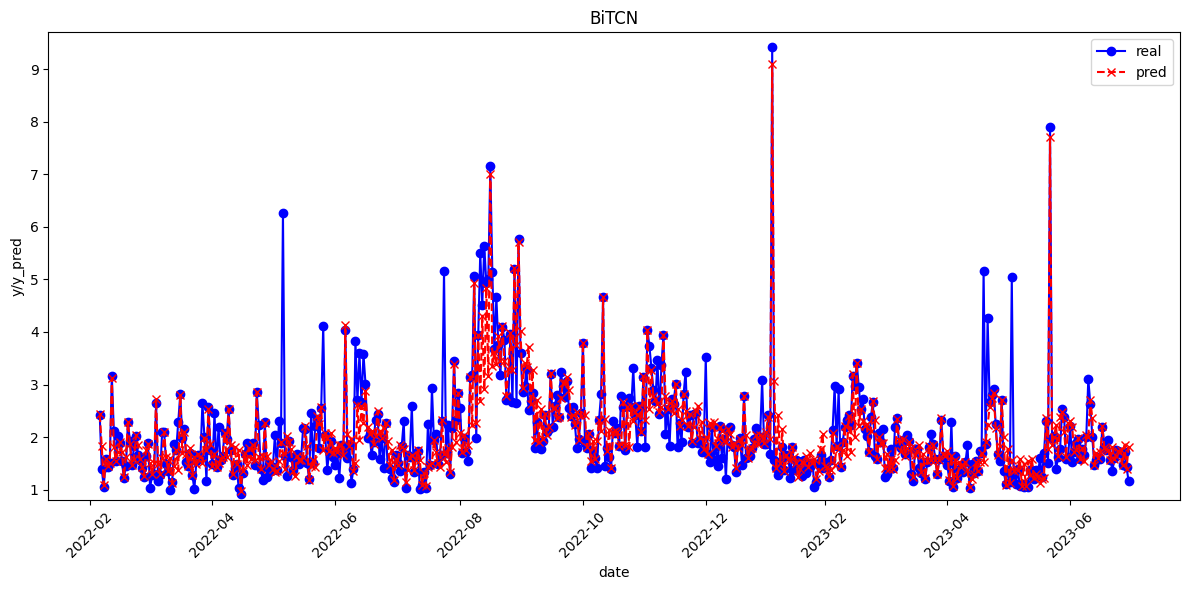

In [77]:
plt.figure(figsize=(12, 6))

# 绘制真实值（测试集）
plt.plot(dates, test_Y_df3['y'], label='real', color='blue', marker='o')

# 绘制预测值
plt.plot(dates, Y_pred, label='pred', color='red', linestyle='--', marker='x')

# 添加图例
plt.legend()

# 设置标题和标签
plt.title('BiTCN')
plt.xlabel('date')
plt.ylabel('y/y_pred')
 #Fit of out-of-sample predicted and true values
# 旋转 x 轴的标签，防止日期显示不清楚
plt.xticks(rotation=45)
# 设置 y 轴范围，调整 y 轴最小值和最大值
plt.ylim(0.8,9.7)  # 将 y 轴范围缩小到 [-0.5, 0.5]
# 显示图形
plt.tight_layout()
plt.show()

In [78]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
Y = test_Y_df3['y']
# 计算均方误差 (MSE)
mse = mean_squared_error(Y_pred, Y)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_pred, Y)
print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 0.5724104374729408
MAE: 0.2803943885794383


### 7.基准模型har-rv

In [79]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Set random seed for reproducibility
np.random.seed(123)

# Read in data
rv_daily = Y_df1

# Filter out rows with missing values
rv_daily = rv_daily.dropna()

# Store predictions in a list
pred = []

# Length of the dataset minus the number of training observations（后面减去的是训练集个数）
lengthr = len(rv_daily['value']) - 722

# Rolling forecast
for i in range(lengthr):
    # Training set range
    train_start = i  # Start at the very beginning
    train_end = 721 + i  # i加上的是训练集个数减一

    # Extract training and test data
    train_data = rv_daily.iloc[train_start:train_end + 1]
    test_data = rv_daily.iloc[train_end + 1 ]

    # Ensure that train_data has lag variables

    # Define training predictors and response
    X_train = train_data[['lag1', 'lag5', 'lag22']]
    y_train = train_data['value']

    # Add constant to the model (intercept)
    X_train = sm.add_constant(X_train)

    # Fit the model
    har_rv = sm.OLS(y_train, X_train).fit()

    # Prepare test data for prediction (same predictors as the training data)
    X_test = test_data[['lag1', 'lag5', 'lag22']].values.reshape(1, -1)  # Ensure it's 2D
    X_test = sm.add_constant(X_test, has_constant='add')  # Add constant to test data

    # Predicting the next value
    forecast_value = har_rv.predict(X_test)

    # Store the predicted value
    pred.append(forecast_value[0])

# Output predictions
print(pred)


[1.8246158205643175, 2.093153146629005, 1.7673784057153885, 1.5734445441683815, 1.6879327994737157, 1.6177235725925647, 1.6005609280597959, 2.26326906191722, 1.9720026603548089, 1.7844353166334388, 1.9701342596323244, 1.9490479533277516, 1.7477971304991302, 1.5859198476198824, 1.6539432459100685, 1.9501723729616018, 1.8328492160819265, 1.6700463652231015, 1.8211091991443216, 1.9223102597493456, 1.7681069937383165, 1.7007321262428716, 1.6487096792286116, 1.548719384375445, 1.6637917379459666, 1.7652088167832518, 1.4487632947900595, 1.5210926502242375, 1.52962688306495, 2.026077825184641, 1.4842700629072016, 1.5306944939809273, 1.8497065465453917, 1.8914150497843967, 1.6266463670964657, 1.5979983953237475, 1.4592697575012883, 1.4501258480463326, 1.682566516284356, 1.661025920802888, 1.8926957840445722, 2.1686919655899213, 1.9327912392485938, 2.013306627984495, 1.791507269267132, 1.7238323938944515, 1.7527392535663995, 1.5675712524217218, 1.4182467095610305, 1.6002661280078216, 1.65227925

In [80]:
# 转换为 DataFrame 一列
pred = pd.DataFrame(pred, columns=["Pred"])

# 查看结果
print(pred)

         Pred
0    1.824616
1    2.093153
2    1.767378
3    1.573445
4    1.687933
..        ...
507  1.773162
508  1.779771
509  1.758548
510  1.801543
511  1.731957

[512 rows x 1 columns]


### 8.绘制harrv测试集图像并计算基于harrv的nbeatsx的R方

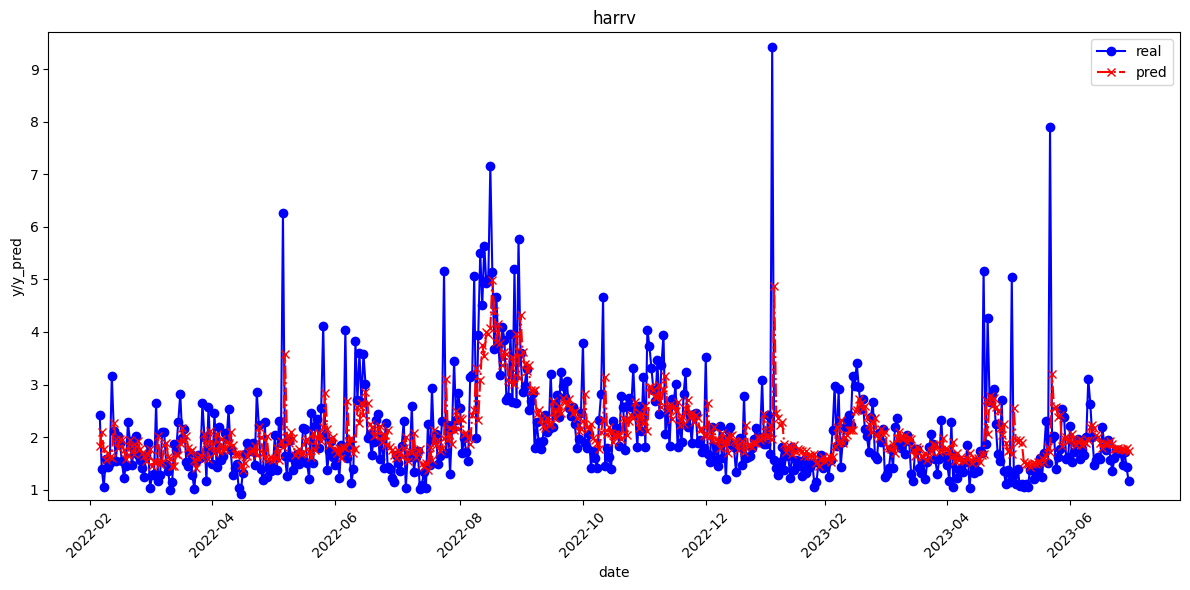

In [81]:
plt.figure(figsize=(12, 6))

# 绘制真实值（测试集）
plt.plot(dates, test_Y_df3['y'], label='real', color='blue', marker='o')

# 绘制预测值
plt.plot(dates, pred['Pred'], label='pred', color='red', linestyle='-.', marker='x')

# 添加图例
plt.legend()

# 设置标题和标签
plt.title('harrv')
plt.xlabel('date')
plt.ylabel('y/y_pred')

# 旋转 x 轴的标签，防止日期显示不清楚
plt.xticks(rotation=45)
# 设置 y 轴范围，调整 y 轴最小值和最大值
plt.ylim(0.8, 9.7)
# 显示图形
plt.tight_layout()
plt.show()

In [82]:
molecular = np.sum((Y_pred['Values'] - Y)**2)
print(molecular)
denominator = np.sum((pred['Pred'] - Y)**2)
print(denominator)

167.75869897111733
369.8370029625121


In [83]:
r2 = 1 - molecular/denominator
print(r2)

0.5463982845758624


In [84]:
#rmse mae of harrv
mse_har = mean_squared_error(pred, Y)

rmse_har = np.sqrt(mse_har)

mae_har = mean_absolute_error(pred, Y)

print(rmse_har)
print(mae_har )

0.849904639598559
0.5280458989849568


In [85]:
import pandas as pd

# 假设 Y_pred 和 Pred 是 pandas DataFrame 或 Series
Y_pred_df = pd.DataFrame(Y_pred, columns=['Values'])  # 将 Y_pred 转换为 DataFrame
Pred_df = pd.DataFrame(pred, columns=['Pred'])  # 将 Pred 转换为 DataFrame

# 合并为一个文件，或者分别保存
result_df = pd.concat([Y_pred_df, Pred_df], axis=1)  # 按列合并

# 保存为 CSV 文件
result_df.to_csv('predictions_BiTCN_har_512_noexpanding.csv', index=False)

